In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from torch.nn import Conv2d
from matplotlib import pyplot as plt
from utilities import Old_CNN_bw, Old_CNN_color
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score

In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [3]:
#"../../../shenhao/sat_image_nhts/code/data_process/"

import pickle
with open('../census_id_to_index.pickle', 'rb') as handle:
    census_id_to_index = pickle.load(handle)

In [4]:
def training(image_array, x_id_train, y_train, x_id_test, y_test, cnn_net, optimizer, criterion, row_name, col_name, n_epochs = 100, batch_size = 200):
#More memory efficient?

    #training
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    validate_losses = []
    validate_accuracies = []

    validate_losses_running = []
    validate_accurate_running = []


    test_indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in x_id_test]
    x_test_images = image_array[test_indices,:,:,:]
    x_test_images_norm_torch = torch.as_tensor(x_test_images).float()/255.0
    
    
    y_train_torch = torch.as_tensor(y_train[:,0]).float()
    y_test_torch = torch.as_tensor(y_test[:,0]).float()
    
    
    print("Training started: ")

    for n_epoch in range(n_epoches):
        # create permutation for batch training
        # To-Do: add permutation for SGD...But it is slow.
        #permutation = torch.randperm(x_train_images_norm_torch.size()[0])
        print("epoch: ", n_epoch)
        for i in tqdm(range(0, x_id_train.shape[0], batch_size)):
            # clear gradients first (for each iteration!)!
            optim.zero_grad()
            # forward pass

            #Get the indices in the image array of this batch
            ids = x_id_train[i:i+batch_size]
            indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

            #convert to torch and normalize
            to_torch = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0

            batch_x, batch_y = to_torch.to(device), y_train_torch[i:i+batch_size].to(device)

            batch_y_pred_train = cnn_net(batch_x)
            # loss 
            
            loss = criterion(batch_y_pred_train.squeeze(), batch_y)
            # compute gradients
            loss.backward()
            # one step optim
            optim.step()

        # eval training accuracy
        with torch.no_grad():
            # evaluate training loss/accuracy in batches


            train_losses_running = []
            train_accurate_running = []

            validate_losses_running = []
            validate_accurate_running = []


            for i in range(0, x_id_train.shape[0], batch_size):

                # load batch data
                ids = x_id_train[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

                batch_image_train_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_train = y_train_torch[i:i+batch_size].to(device)
                y_batch_probs_train = cnn_net(batch_image_train_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_train.size()[0]
                loss_train = criterion(y_batch_probs_train.squeeze(), batch_y_train)
                train_losses_running.append(loss_train.item())

                # evaluate accuracy on current batch
                _, batch_predict_train = torch.max(y_batch_probs_train, axis = 1)
                accurate_pred_train = r2_score(y_true=batch_y_train.cpu(), y_pred=batch_predict_train.cpu())
                train_accurate_running.append(accurate_pred_train)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            train_losses.append(sum(train_losses_running)) # average loss per epoch
            train_accuracies.append(sum(train_accurate_running) / x_id_train.shape[0]) # average accuracy per epoch


            # evaluate validation accuracy/loss in batches
            for i in range(0, x_id_test.shape[0], batch_size):

                # load batch data

                ids = x_id_test[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]


                batch_image_val_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_val = y_test_torch[i:i+batch_size].to(device)
                y_batch_probs_val = cnn_net(batch_image_val_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_val.size()[0]
                loss_validate = criterion(y_batch_probs_val.squeeze(), batch_y_val)
                validate_losses_running.append(loss_validate.item())

                # evaluate accuracy on current batch
                _, batch_predict_val = torch.max(y_batch_probs_val, axis = 1)
                accurate_pred_val = r2_score(y_true=batch_y_val.cpu(), y_pred=batch_predict_val.cpu())
                validate_accurate_running.append(accurate_pred_val)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            validate_losses.append(sum(validate_losses_running)) # average loss per epoch
            validate_accuracies.append(sum(validate_accurate_running) / x_id_test.shape[0]) # average accuracy per epoch


            # print performance updates
            if n_epoch % 5 == 0:
                print("Printing accuracies")
                #_, preds = torch.max(cnn_net(x_test_images_norm_torch.to(device)), axis=1)
                #unique = preds.unique(sorted=True)
                print('Epoch {}: train loss: {}'.format(n_epoch, train_losses[-1]))
                print('Epoch {}: train accuracy: {}'.format(n_epoch, train_accuracies[-1]))
                #print('Epoch {}: prediction counts: {}'.format(n_epoch, [(i.item(), (preds==i).sum().item()) for i in unique] ))
                print('Epoch {}: validate loss: {}'.format(n_epoch, validate_losses[-1]))
                print('Epoch {}: validate accuracy: {}'.format(n_epoch, validate_accuracies[-1]))
            elif n_epoch == 99:
                print("Printing accuracies")
                #_, preds = torch.max(cnn_net(x_test_images_norm_torch.to(device)), axis=1)
                #unique = preds.unique(sorted=True)
                print('Epoch {}: train loss: {}'.format(n_epoch, train_losses[-1]))
                print('Epoch {}: train accuracy: {}'.format(n_epoch, train_accuracies[-1]))
                #print('Epoch {}: prediction counts: {}'.format(n_epoch, [(i.item(), (preds==i).sum().item()) for i in unique] ))
                print('Epoch {}: validate loss: {}'.format(n_epoch, validate_losses[-1]))
                print('Epoch {}: validate accuracy: {}'.format(n_epoch, validate_accuracies[-1]))
                
                for_plotting.append((row_name,col_name,train_losses,validate_losses,train_accuracies,validate_accuracies))
                
                
    return train_losses, validate_losses, train_accuracies, validate_accuracies
   



In [5]:
labels_train = pd.read_csv("encoded_avg_labels_train.csv")
labels_test = pd.read_csv("encoded_avg_labels_test.csv")

In [6]:
labels_train.head()

,CENSUS_ID,HHVEHCNT,TRIPPURP_0,TRIPPURP_1,TRIPPURP_2,TRIPPURP_3,TRIPPURP_4,TRPTRANS_1,TRPTRANS_2,TRPTRANS_3,TRPTRANS_4,TRPTRANS_5,TRPTRANS_6
0,21089040100,2.000000,0.000000,0.000000,0.600000,0.200000,0.200000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000
1,48189950300,1.956522,0.260870,0.130435,0.130435,0.043478,0.434783,0.000000,0.826087,0.000000,0.173913,0.0,0.000000
2,48091310603,1.903226,0.258065,0.225806,0.032258,0.096774,0.387097,0.064516,0.483871,0.000000,0.387097,0.0,0.064516
3,53061051912,2.000000,0.384615,0.076923,0.000000,0.153846,0.384615,0.153846,0.307692,0.538462,0.000000,0.0,0.000000
4,6065031401,3.000000,0.266667,0.066667,0.133333,0.133333,0.400000,0.133333,0.733333,0.000000,0.133333,0.0,0.000000


In [7]:
labels_test.head()

,CENSUS_ID,HHVEHCNT,TRIPPURP_0,TRIPPURP_1,TRIPPURP_2,TRIPPURP_3,TRIPPURP_4,TRPTRANS_1,TRPTRANS_2,TRPTRANS_3,TRPTRANS_4,TRPTRANS_5,TRPTRANS_6
0,12127082802,2.000000,0.250000,0.000000,0.500000,0.000000,0.250000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000
1,25003900400,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,55009002002,2.052174,0.226087,0.217391,0.113043,0.156522,0.286957,0.000000,0.382609,0.347826,0.217391,0.000000,0.052174
3,48201250301,2.333333,0.144928,0.289855,0.072464,0.173913,0.318841,0.028986,0.217391,0.449275,0.173913,0.028986,0.101449
4,48201541300,1.750000,0.178571,0.071429,0.000000,0.357143,0.392857,0.000000,0.500000,0.214286,0.285714,0.000000,0.000000


In [8]:
x_id_train = labels_train["CENSUS_ID"].values.reshape(-1,1)
print(x_id_train.shape)
x_id_test = labels_test["CENSUS_ID"].values.reshape(-1,1)
print(x_id_test.shape)


dependent_variables = list(labels_train.columns[1:])
print(dependent_variables)

(27234, 1)
(5447, 1)
['HHVEHCNT', 'TRIPPURP_0', 'TRIPPURP_1', 'TRIPPURP_2', 'TRIPPURP_3', 'TRIPPURP_4', 'TRPTRANS_1', 'TRPTRANS_2', 'TRPTRANS_3', 'TRPTRANS_4', 'TRPTRANS_5', 'TRPTRANS_6']


In [9]:
image_array_bw = np.load("image_array_bw.npy", mmap_mode = 'r+')
image_array_color = np.load("image_array_color.npy", mmap_mode = 'r+')

In [10]:
models = ["Old_CNN_bw", "Old_CNN_color"]
models_resnet = ["Resnet18_bw", "Resnet18_color"]

In [11]:
results = pd.DataFrame(columns=dependent_variables, index = models + models_resnet)
#[(row_name,col_name,train_losses,validate_losses,train_accuracies,validate_accuracies)]
for_plotting = []

In [12]:
results.head()

,HHVEHCNT,TRIPPURP_0,TRIPPURP_1,TRIPPURP_2,TRIPPURP_3,TRIPPURP_4,TRPTRANS_1,TRPTRANS_2,TRPTRANS_3,TRPTRANS_4,TRPTRANS_5,TRPTRANS_6
Old_CNN_bw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Old_CNN_color,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Resnet18_bw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Resnet18_color,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
%%capture output
for row_name in models:
    for col_name in dependent_variables:
        print("------")
        print(row_name, col_name)
        print("------")
        K = 1
        if row_name == "Old_CNN_bw":
            cnn_net = Old_CNN_bw(K).float().to(device)
            image_array = image_array_bw
            
        elif row_name == "Old_CNN_color":
            cnn_net = Old_CNN_color(K).float().to(device)
            image_array = image_array_color
            
        elif row_name == "Resnet18_bw":
            model_ft = models.resnet18(pretrained=False)
            for param in model_ft.parameters():
                param.requires_grad = True
            model_ft.conv1 = Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            
            
            image_array = image_array_bw
            
        elif row_name == "Resnet18_color":
            model_ft = torchvision.models.resnet18(pretrained=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            image_array = image_array_color
        
        optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        n_epoches = 100 # To-Do: need more epoches.
        batch_size = 200
        #K = 1 here because we are doing regression, so the final layer output should have size 1
        
        
        y_train = labels_train[col_name].values.reshape(-1,1)
        y_test = labels_test[col_name].values.reshape(-1,1)
        
        training(image_array, x_id_train, y_train, x_id_test, y_test, 
                 cnn_net, optim, criterion, row_name, col_name, n_epochs = 100, batch_size = 200)
        print("*********")
        print(for_plotting)
        print("*********")
        
        #torch.cuda.empty_cache()
        

In [13]:
#results from above training
for_plotting = [('Old_CNN_bw', 'HHVEHCNT', 4.1131455248880116, 4.059583382495329, -0.03458188741872873, -0.03463212978995565), ('Old_CNN_bw', 'TRIPPURP_0', 0.06493081235113916, 0.06834958086095645, -0.0040915286789047125, -0.004131484918855007), ('Old_CNN_bw', 'TRIPPURP_1', 0.09624101764008784, 0.10058436792378735, -0.006504472032759999, -0.006260428515212234), ('Old_CNN_bw', 'TRIPPURP_2', 0.0433297978863618, 0.04451428823773524, -0.0024651701502092036, -0.0023893859364937193), ('Old_CNN_bw', 'TRIPPURP_3', 0.07266340015559082, 0.06657558462368976, -0.0031594463586950418, -0.003188653650093755), ('Old_CNN_bw', 'TRIPPURP_4', 0.1383930039200531, 0.1398924474204508, -0.012684891499088908, -0.012945609344295532), ('Old_CNN_bw', 'TRPTRANS_1', 0.037497294388039545, 0.034476792208312824, -0.0011897044786947824, -0.0011325956886603736), ('Old_CNN_bw', 'TRPTRANS_2', 0.3352449192339483, 0.3456775530042923, -0.008898592927181285, -0.00889476579723966), ('Old_CNN_bw', 'TRPTRANS_3', 0.14546690670707865, 0.14322468401511612, -0.003198388791955348, -0.0030229213404769097), ('Old_CNN_bw', 'TRPTRANS_4', 0.09741004643578917, 0.10341259061316295, -0.0021859093663842318, -0.0022580719935941275), ('Old_CNN_bw', 'TRPTRANS_5', 0.013434253995536731, 0.014474231944010504, -0.00033106526757371147, -0.000329090846943703), ('Old_CNN_bw', 'TRPTRANS_6', 0.007369766884371983, 0.007999036826037486, -0.0002843177759690532, -0.0002808020046864036), ('Old_CNN_color', 'HHVEHCNT', 4.1131455248880116, 4.059583382495329, -0.03458188741872873, -0.03463212978995565), ('Old_CNN_color', 'TRIPPURP_0', 0.06493081235113916, 0.06834958086095645, -0.0040915286789047125, -0.004131484918855007), ('Old_CNN_color', 'TRIPPURP_1', 0.09624101764008784, 0.10058436792378735, -0.006504472032759999, -0.006260428515212234), ('Old_CNN_color', 'TRIPPURP_2', 0.0433297978863618, 0.04451428823773524, -0.0024651701502092036, -0.0023893859364937193), ('Old_CNN_color', 'TRIPPURP_3', 0.07266340015559082, 0.06657558462368976, -0.0031594463586950418, -0.003188653650093755), ('Old_CNN_color', 'TRIPPURP_4', 0.1383930039200531, 0.1398924474204508, -0.012684891499088908, -0.012945609344295532), ('Old_CNN_color', 'TRPTRANS_1', 0.037497294388039545, 0.034476792208312824, -0.0011897044786947824, -0.0011325956886603736), ('Old_CNN_color', 'TRPTRANS_2', 0.3352449192339483, 0.3456775530042923, -0.008898592927181285, -0.00889476579723966), ('Old_CNN_color', 'TRPTRANS_3', 0.14546690670707865, 0.14322468401511612, -0.003198388791955348, -0.0030229213404769097), ('Old_CNN_color', 'TRPTRANS_4', 0.09741004643578917, 0.10341259061316295, -0.0021859093663842318, -0.0022580719935941275), ('Old_CNN_color', 'TRPTRANS_5', 0.013434253995536731, 0.014474231944010504, -0.00033106526757371147, -0.000329090846943703), ('Old_CNN_color', 'TRPTRANS_6', 0.007369766884371983, 0.007999036826037486, -0.0002843177759690532, -0.0002808020046864036)]
print(for_plotting)

[('Old_CNN_bw', 'HHVEHCNT', 4.1131455248880116, 4.059583382495329, -0.03458188741872873, -0.03463212978995565), ('Old_CNN_bw', 'TRIPPURP_0', 0.06493081235113916, 0.06834958086095645, -0.0040915286789047125, -0.004131484918855007), ('Old_CNN_bw', 'TRIPPURP_1', 0.09624101764008784, 0.10058436792378735, -0.006504472032759999, -0.006260428515212234), ('Old_CNN_bw', 'TRIPPURP_2', 0.0433297978863618, 0.04451428823773524, -0.0024651701502092036, -0.0023893859364937193), ('Old_CNN_bw', 'TRIPPURP_3', 0.07266340015559082, 0.06657558462368976, -0.0031594463586950418, -0.003188653650093755), ('Old_CNN_bw', 'TRIPPURP_4', 0.1383930039200531, 0.1398924474204508, -0.012684891499088908, -0.012945609344295532), ('Old_CNN_bw', 'TRPTRANS_1', 0.037497294388039545, 0.034476792208312824, -0.0011897044786947824, -0.0011325956886603736), ('Old_CNN_bw', 'TRPTRANS_2', 0.3352449192339483, 0.3456775530042923, -0.008898592927181285, -0.00889476579723966), ('Old_CNN_bw', 'TRPTRANS_3', 0.14546690670707865, 0.14322468

In [14]:
for row_name,col_name,train_losses,validate_losses,train_accuracies,validate_accuracies in for_plotting:
    results.loc[row_name][col_name] = train_losses,validate_losses,train_accuracies,validate_accuracies

In [15]:
results.head()

,HHVEHCNT,TRIPPURP_0,TRIPPURP_1,TRIPPURP_2,TRIPPURP_3,TRIPPURP_4,TRPTRANS_1,TRPTRANS_2,TRPTRANS_3,TRPTRANS_4,TRPTRANS_5,TRPTRANS_6
Old_CNN_bw,"(4.1131455248880116, 4.059583382495329, -0.034...","(0.06493081235113916, 0.06834958086095645, -0....","(0.09624101764008784, 0.10058436792378735, -0....","(0.0433297978863618, 0.04451428823773524, -0.0...","(0.07266340015559082, 0.06657558462368976, -0....","(0.1383930039200531, 0.1398924474204508, -0.01...","(0.037497294388039545, 0.034476792208312824, -...","(0.3352449192339483, 0.3456775530042923, -0.00...","(0.14546690670707865, 0.14322468401511612, -0....","(0.09741004643578917, 0.10341259061316295, -0....","(0.013434253995536731, 0.014474231944010504, -...","(0.007369766884371983, 0.007999036826037486, -..."
Old_CNN_color,"(4.1131455248880116, 4.059583382495329, -0.034...","(0.06493081235113916, 0.06834958086095645, -0....","(0.09624101764008784, 0.10058436792378735, -0....","(0.0433297978863618, 0.04451428823773524, -0.0...","(0.07266340015559082, 0.06657558462368976, -0....","(0.1383930039200531, 0.1398924474204508, -0.01...","(0.037497294388039545, 0.034476792208312824, -...","(0.3352449192339483, 0.3456775530042923, -0.00...","(0.14546690670707865, 0.14322468401511612, -0....","(0.09741004643578917, 0.10341259061316295, -0....","(0.013434253995536731, 0.014474231944010504, -...","(0.007369766884371983, 0.007999036826037486, -..."
Resnet18_bw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Resnet18_color,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
models = ["Resnet18_bw", "Resnet18_color"]

In [17]:
for_plotting = []

In [ ]:
#%%capture output
for row_name in models:
    for col_name in dependent_variables:
        print("------")
        print(row_name, col_name)
        print("------")
        K = 1
        if row_name == "Old_CNN_bw":
            cnn_net = Old_CNN_bw(K).float().to(device)
            image_array = image_array_bw
            
        elif row_name == "Old_CNN_color":
            cnn_net = Old_CNN_color(K).float().to(device)
            image_array = image_array_color
            
        elif row_name == "Resnet18_bw":
            model_ft = torchvision.models.resnet18(pretrained=False)
            for param in model_ft.parameters():
                param.requires_grad = True
            model_ft.conv1 = Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            
            
            image_array = image_array_bw
            
        elif row_name == "Resnet18_color":
            model_ft = torchvision.models.resnet18(pretrained=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            image_array = image_array_color
        
        optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        n_epoches = 100 # To-Do: need more epoches.
        batch_size = 200
        #K = 1 here because we are doing regression, so the final layer output should have size 1
        
        
        y_train = labels_train[col_name].values.reshape(-1,1)
        y_test = labels_test[col_name].values.reshape(-1,1)
        
        training(image_array, x_id_train, y_train, x_id_test, y_test, 
                 cnn_net, optim, criterion, row_name, col_name, n_epochs = 100, batch_size = 200)
        print("*********")
        print(for_plotting)
        print("*********")
        
        #torch.cuda.empty_cache()

------
Resnet18_bw HHVEHCNT
------
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 81.58918869495392
Epoch 0: train accuracy: -0.03458188741872873
Epoch 0: validate loss: 16.74357435107231
Epoch 0: validate accuracy: -0.03463212978995565
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 73.88624691963196
Epoch 5: train accuracy: -0.03458188741872873
Epoch 5: validate loss: 15.22149732708931
Epoch 5: validate accuracy: -0.03463212978995565
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 76.21151307225227
Epoch 10: train accuracy: -0.03458188741872873
Epoch 10: validate loss: 15.872616976499557
Epoch 10: validate accuracy: -0.03463212978995565
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 71.22945973277092
Epoch 15: train accuracy: -0.03458188741872873
Epoch 15: validate loss: 15.053879708051682
Epoch 15: validate accuracy: -0.03463212978995565
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 64.81834436953068
Epoch 20: train accuracy: -0.03458188741872873
Epoch 20: validate loss: 15.88853070139885
Epoch 20: validate accuracy: -0.03463212978995565
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 50.60946547985077
Epoch 25: train accuracy: -0.03458188741872873
Epoch 25: validate loss: 17.619570791721344
Epoch 25: validate accuracy: -0.03463212978995565
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 37.92444030940533
Epoch 30: train accuracy: -0.03458188741872873
Epoch 30: validate loss: 19.954747140407562
Epoch 30: validate accuracy: -0.03463212978995565
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 39.2598592787981
Epoch 35: train accuracy: -0.03458188741872873
Epoch 35: validate loss: 20.74285465478897
Epoch 35: validate accuracy: -0.03463212978995565
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 32.553716484457254
Epoch 40: train accuracy: -0.03458188741872873
Epoch 40: validate loss: 21.503455758094788
Epoch 40: validate accuracy: -0.03463212978995565
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 30.753884045407176
Epoch 45: train accuracy: -0.03458188741872873
Epoch 45: validate loss: 21.627916157245636
Epoch 45: validate accuracy: -0.03463212978995565
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 25.348756295628846
Epoch 50: train accuracy: -0.03458188741872873
Epoch 50: validate loss: 21.54487293958664
Epoch 50: validate accuracy: -0.03463212978995565
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 25.91976675018668
Epoch 55: train accuracy: -0.03458188741872873
Epoch 55: validate loss: 22.92240858078003
Epoch 55: validate accuracy: -0.03463212978995565
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 20.084375895559788
Epoch 60: train accuracy: -0.03458188741872873
Epoch 60: validate loss: 22.095230102539062
Epoch 60: validate accuracy: -0.03463212978995565
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 19.917597899213433
Epoch 65: train accuracy: -0.03458188741872873
Epoch 65: validate loss: 21.4475519657135
Epoch 65: validate accuracy: -0.03463212978995565
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 20.230336096137762
Epoch 70: train accuracy: -0.03458188741872873
Epoch 70: validate loss: 23.22185969352722
Epoch 70: validate accuracy: -0.03463212978995565
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 15.4281150624156
Epoch 75: train accuracy: -0.03458188741872873
Epoch 75: validate loss: 22.069669127464294
Epoch 75: validate accuracy: -0.03463212978995565
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 17.48605603631586
Epoch 80: train accuracy: -0.03458188741872873
Epoch 80: validate loss: 23.585799276828766
Epoch 80: validate accuracy: -0.03463212978995565
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 11.379508377052844
Epoch 85: train accuracy: -0.03458188741872873
Epoch 85: validate loss: 22.455354928970337
Epoch 85: validate accuracy: -0.03463212978995565
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 12.473751466721296
Epoch 90: train accuracy: -0.03458188741872873
Epoch 90: validate loss: 23.266415119171143
Epoch 90: validate accuracy: -0.03463212978995565
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 12.892566356807947
Epoch 95: train accuracy: -0.03458188741872873
Epoch 95: validate loss: 21.983373939990997
Epoch 95: validate accuracy: -0.03463212978995565
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 12.015219861641526
Epoch 99: train accuracy: -0.03458188741872873
Epoch 99: validate loss: 24.247070491313934
Epoch 99: validate accuracy: -0.03463212978995565
*********
[('Resnet18_bw', 'HHVEHCNT', [81.58918869495392, 73.25767862796783, 72.63822114467621, 72.90453064441681, 73.24891993403435, 73.88624691963196, 74.23740842938423, 72.20157432556152, 74.85993972420692, 77.39994004368782, 76.21151307225227, 77.92784807085991, 75.47140446305275, 73.81901949644089, 72.47560933232307, 71.22945973277092, 71.07830157876015, 70.8656553030014, 69.72404706478119, 68.3040081858635, 64.81834436953068, 62.83014741539955, 58.735793724656105, 55.2106968164444, 52.36703608930111, 50.60946547985077, 48.40725600719452, 45.391839273273945, 42.69756065309048, 40.140080630779266, 37.92444030940533, 37.46468346193433, 38.07064566761255, 37.115676783025265, 36.86082288250327, 39.2598592787981, 35.92098079621792, 30.83031902834773, 32.26315087918192, 36.1222722921520

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 5.097966438159347
Epoch 0: train accuracy: -0.0040915286789047125
Epoch 0: validate loss: 1.1112271007150412
Epoch 0: validate accuracy: -0.004131484918855007
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 5.875966662541032
Epoch 5: train accuracy: -0.0040915286789047125
Epoch 5: validate loss: 1.267755202949047
Epoch 5: validate accuracy: -0.004131484918855007
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 6.31927097402513
Epoch 10: train accuracy: -0.0040915286789047125
Epoch 10: validate loss: 1.3820167612284422
Epoch 10: validate accuracy: -0.004131484918855007
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.442951450124383
Epoch 15: train accuracy: -0.0040915286789047125
Epoch 15: validate loss: 1.1905444953590631
Epoch 15: validate accuracy: -0.004131484918855007
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 5.473372038453817
Epoch 20: train accuracy: -0.0040915286789047125
Epoch 20: validate loss: 1.1912073362618685
Epoch 20: validate accuracy: -0.004131484918855007
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 4.979109384119511
Epoch 25: train accuracy: -0.0040915286789047125
Epoch 25: validate loss: 1.1189087312668562
Epoch 25: validate accuracy: -0.004131484918855007
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 5.042248260229826
Epoch 30: train accuracy: -0.0040915286789047125
Epoch 30: validate loss: 1.0934886168688536
Epoch 30: validate accuracy: -0.004131484918855007
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 4.943022916093469
Epoch 35: train accuracy: -0.0040915286789047125
Epoch 35: validate loss: 1.0736879277974367
Epoch 35: validate accuracy: -0.004131484918855007
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 4.931204114109278
Epoch 40: train accuracy: -0.0040915286789047125
Epoch 40: validate loss: 1.0755477584898472
Epoch 40: validate accuracy: -0.004131484918855007
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 4.91840697824955
Epoch 45: train accuracy: -0.0040915286789047125
Epoch 45: validate loss: 1.079664221033454
Epoch 45: validate accuracy: -0.004131484918855007
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 4.9094399474561214
Epoch 50: train accuracy: -0.0040915286789047125
Epoch 50: validate loss: 1.0862412210553885
Epoch 50: validate accuracy: -0.004131484918855007
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 4.8715015556663275
Epoch 55: train accuracy: -0.0040915286789047125
Epoch 55: validate loss: 1.0847354084253311
Epoch 55: validate accuracy: -0.004131484918855007
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 4.8672498520463705
Epoch 60: train accuracy: -0.0040915286789047125
Epoch 60: validate loss: 1.0888523571193218
Epoch 60: validate accuracy: -0.004131484918855007
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 4.82848079316318
Epoch 65: train accuracy: -0.0040915286789047125
Epoch 65: validate loss: 1.0951625779271126
Epoch 65: validate accuracy: -0.004131484918855007
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 4.7417216170579195
Epoch 70: train accuracy: -0.0040915286789047125
Epoch 70: validate loss: 1.1455925907939672
Epoch 70: validate accuracy: -0.004131484918855007
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 4.484453435987234
Epoch 75: train accuracy: -0.0040915286789047125
Epoch 75: validate loss: 1.1596474908292294
Epoch 75: validate accuracy: -0.004131484918855007
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 4.063446303829551
Epoch 80: train accuracy: -0.0040915286789047125
Epoch 80: validate loss: 1.1710464153438807
Epoch 80: validate accuracy: -0.004131484918855007
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 3.3965225908905268
Epoch 85: train accuracy: -0.0040915286789047125
Epoch 85: validate loss: 1.3214617669582367
Epoch 85: validate accuracy: -0.004131484918855007
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 2.4819433856755495
Epoch 90: train accuracy: -0.0040915286789047125
Epoch 90: validate loss: 1.343547498807311
Epoch 90: validate accuracy: -0.004131484918855007
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.7738708616234362
Epoch 95: train accuracy: -0.0040915286789047125
Epoch 95: validate loss: 1.2972394991666079
Epoch 95: validate accuracy: -0.004131484918855007
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 1.5679400404915214
Epoch 99: train accuracy: -0.0040915286789047125
Epoch 99: validate loss: 1.3392807208001614
Epoch 99: validate accuracy: -0.004131484918855007
*********
[('Resnet18_bw', 'HHVEHCNT', [81.58918869495392, 73.25767862796783, 72.63822114467621, 72.90453064441681, 73.24891993403435, 73.88624691963196, 74.23740842938423, 72.20157432556152, 74.85993972420692, 77.39994004368782, 76.21151307225227, 77.92784807085991, 75.47140446305275, 73.81901949644089, 72.47560933232307, 71.22945973277092, 71.07830157876015, 70.8656553030014, 69.72404706478119, 68.3040081858635, 64.81834436953068, 62.83014741539955, 58.735793724656105, 55.2106968164444, 52.36703608930111, 50.60946547985077, 48.40725600719452, 45.391839273273945, 42.69756065309048, 40.140080630779266, 37.92444030940533, 37.46468346193433, 38.07064566761255, 37.115676783025265, 36.86082288250327, 39.2598592787981, 35.92098079621792, 30.83031902834773, 32.26315087918192, 36.1222722921

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 8.31345635280013
Epoch 0: train accuracy: -0.006504472032759999
Epoch 0: validate loss: 1.7266238890588284
Epoch 0: validate accuracy: -0.006260428515212234
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 6.5756848976016045
Epoch 5: train accuracy: -0.006504472032759999
Epoch 5: validate loss: 1.4329807497560978
Epoch 5: validate accuracy: -0.006260428515212234
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 5.9487758371979
Epoch 10: train accuracy: -0.006504472032759999
Epoch 10: validate loss: 1.3050290048122406
Epoch 10: validate accuracy: -0.006260428515212234
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.878664061427116
Epoch 15: train accuracy: -0.006504472032759999
Epoch 15: validate loss: 1.28621269389987
Epoch 15: validate accuracy: -0.006260428515212234
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 5.975358912721276
Epoch 20: train accuracy: -0.006504472032759999
Epoch 20: validate loss: 1.3161558136343956
Epoch 20: validate accuracy: -0.006260428515212234
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 5.823858760297298
Epoch 25: train accuracy: -0.006504472032759999
Epoch 25: validate loss: 1.292150653898716
Epoch 25: validate accuracy: -0.006260428515212234
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 5.851705649867654
Epoch 30: train accuracy: -0.006504472032759999
Epoch 30: validate loss: 1.353755623102188
Epoch 30: validate accuracy: -0.006260428515212234
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 5.292887901887298
Epoch 35: train accuracy: -0.006504472032759999
Epoch 35: validate loss: 1.3522769324481487
Epoch 35: validate accuracy: -0.006260428515212234
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 4.980350213125348
Epoch 40: train accuracy: -0.006504472032759999
Epoch 40: validate loss: 1.5609797798097134
Epoch 40: validate accuracy: -0.006260428515212234
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 4.398686985485256
Epoch 45: train accuracy: -0.006504472032759999
Epoch 45: validate loss: 1.7374715730547905
Epoch 45: validate accuracy: -0.006260428515212234
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 3.3315032003447413
Epoch 50: train accuracy: -0.006504472032759999
Epoch 50: validate loss: 1.6581814773380756
Epoch 50: validate accuracy: -0.006260428515212234
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 2.713490762747824
Epoch 55: train accuracy: -0.006504472032759999
Epoch 55: validate loss: 1.7271345406770706
Epoch 55: validate accuracy: -0.006260428515212234
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 2.3523982940241694
Epoch 60: train accuracy: -0.006504472032759999
Epoch 60: validate loss: 1.7454386092722416
Epoch 60: validate accuracy: -0.006260428515212234
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 2.1788734449073672
Epoch 65: train accuracy: -0.006504472032759999
Epoch 65: validate loss: 1.7318039759993553
Epoch 65: validate accuracy: -0.006260428515212234
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.7525300444103777
Epoch 70: train accuracy: -0.006504472032759999
Epoch 70: validate loss: 1.7260546274483204
Epoch 70: validate accuracy: -0.006260428515212234
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.5714229415170848
Epoch 75: train accuracy: -0.006504472032759999
Epoch 75: validate loss: 1.7168662659823895
Epoch 75: validate accuracy: -0.006260428515212234
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.5222509863087907
Epoch 80: train accuracy: -0.006504472032759999
Epoch 80: validate loss: 1.817112524062395
Epoch 80: validate accuracy: -0.006260428515212234
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.542598866741173
Epoch 85: train accuracy: -0.006504472032759999
Epoch 85: validate loss: 1.79262850061059
Epoch 85: validate accuracy: -0.006260428515212234
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.4660354175139219
Epoch 90: train accuracy: -0.006504472032759999
Epoch 90: validate loss: 1.8026420921087265
Epoch 90: validate accuracy: -0.006260428515212234
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.227060257922858
Epoch 95: train accuracy: -0.006504472032759999
Epoch 95: validate loss: 1.8154291696846485
Epoch 95: validate accuracy: -0.006260428515212234
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 1.1091129016131163
Epoch 99: train accuracy: -0.006504472032759999
Epoch 99: validate loss: 1.737958986312151
Epoch 99: validate accuracy: -0.006260428515212234
*********
[('Resnet18_bw', 'HHVEHCNT', [81.58918869495392, 73.25767862796783, 72.63822114467621, 72.90453064441681, 73.24891993403435, 73.88624691963196, 74.23740842938423, 72.20157432556152, 74.85993972420692, 77.39994004368782, 76.21151307225227, 77.92784807085991, 75.47140446305275, 73.81901949644089, 72.47560933232307, 71.22945973277092, 71.07830157876015, 70.8656553030014, 69.72404706478119, 68.3040081858635, 64.81834436953068, 62.83014741539955, 58.735793724656105, 55.2106968164444, 52.36703608930111, 50.60946547985077, 48.40725600719452, 45.391839273273945, 42.69756065309048, 40.140080630779266, 37.92444030940533, 37.46468346193433, 38.07064566761255, 37.115676783025265, 36.86082288250327, 39.2598592787981, 35.92098079621792, 30.83031902834773, 32.26315087918192, 36.122272292152

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 5.38159859739244
Epoch 0: train accuracy: -0.0024651701502092036
Epoch 0: validate loss: 1.1341368667781353
Epoch 0: validate accuracy: -0.0023893859364937193
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 4.30836945772171
Epoch 5: train accuracy: -0.0024651701502092036
Epoch 5: validate loss: 0.9273573840036988
Epoch 5: validate accuracy: -0.0023893859364937193
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 4.956124257296324
Epoch 10: train accuracy: -0.0024651701502092036
Epoch 10: validate loss: 1.0550414882600307
Epoch 10: validate accuracy: -0.0023893859364937193
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 4.160571177490056
Epoch 15: train accuracy: -0.0024651701502092036
Epoch 15: validate loss: 0.8985897935926914
Epoch 15: validate accuracy: -0.0023893859364937193
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 4.133521853946149
Epoch 20: train accuracy: -0.0024651701502092036
Epoch 20: validate loss: 0.8902916125953197
Epoch 20: validate accuracy: -0.0023893859364937193
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 4.069512483663857
Epoch 25: train accuracy: -0.0024651701502092036
Epoch 25: validate loss: 0.8802095549181104
Epoch 25: validate accuracy: -0.0023893859364937193
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 4.072536438703537
Epoch 30: train accuracy: -0.0024651701502092036
Epoch 30: validate loss: 0.8968676161020994
Epoch 30: validate accuracy: -0.0023893859364937193
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 4.002523728646338
Epoch 35: train accuracy: -0.0024651701502092036
Epoch 35: validate loss: 0.9543490689247847
Epoch 35: validate accuracy: -0.0023893859364937193
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 3.532653173431754
Epoch 40: train accuracy: -0.0024651701502092036
Epoch 40: validate loss: 1.0020741112530231
Epoch 40: validate accuracy: -0.0023893859364937193
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 3.0919248443096876
Epoch 45: train accuracy: -0.0024651701502092036
Epoch 45: validate loss: 0.9907946232706308
Epoch 45: validate accuracy: -0.0023893859364937193
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 2.8392446925863624
Epoch 50: train accuracy: -0.0024651701502092036
Epoch 50: validate loss: 1.0894140750169754
Epoch 50: validate accuracy: -0.0023893859364937193
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 2.3131238082423806
Epoch 55: train accuracy: -0.0024651701502092036
Epoch 55: validate loss: 1.029281722381711
Epoch 55: validate accuracy: -0.0023893859364937193
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 2.140732912812382
Epoch 60: train accuracy: -0.0024651701502092036
Epoch 60: validate loss: 0.9981631580740213
Epoch 60: validate accuracy: -0.0023893859364937193
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.8688723961822689
Epoch 65: train accuracy: -0.0024651701502092036
Epoch 65: validate loss: 1.0810947734862566
Epoch 65: validate accuracy: -0.0023893859364937193
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.7897475278005004
Epoch 70: train accuracy: -0.0024651701502092036
Epoch 70: validate loss: 1.1150856502354145
Epoch 70: validate accuracy: -0.0023893859364937193
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.8572176047600806
Epoch 75: train accuracy: -0.0024651701502092036
Epoch 75: validate loss: 1.149348333477974
Epoch 75: validate accuracy: -0.0023893859364937193
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.3854671805165708
Epoch 80: train accuracy: -0.0024651701502092036
Epoch 80: validate loss: 1.1166949514299631
Epoch 80: validate accuracy: -0.0023893859364937193
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.447996312752366
Epoch 85: train accuracy: -0.0024651701502092036
Epoch 85: validate loss: 1.0604488290846348
Epoch 85: validate accuracy: -0.0023893859364937193
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.2321628463687375
Epoch 90: train accuracy: -0.0024651701502092036
Epoch 90: validate loss: 1.1624433286488056
Epoch 90: validate accuracy: -0.0023893859364937193
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.0628073742846027
Epoch 95: train accuracy: -0.0024651701502092036
Epoch 95: validate loss: 1.0927581377327442
Epoch 95: validate accuracy: -0.0023893859364937193
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 1.2107878390233964
Epoch 99: train accuracy: -0.0024651701502092036
Epoch 99: validate loss: 1.1745958868414164
Epoch 99: validate accuracy: -0.0023893859364937193
*********
[('Resnet18_bw', 'HHVEHCNT', [81.58918869495392, 73.25767862796783, 72.63822114467621, 72.90453064441681, 73.24891993403435, 73.88624691963196, 74.23740842938423, 72.20157432556152, 74.85993972420692, 77.39994004368782, 76.21151307225227, 77.92784807085991, 75.47140446305275, 73.81901949644089, 72.47560933232307, 71.22945973277092, 71.07830157876015, 70.8656553030014, 69.72404706478119, 68.3040081858635, 64.81834436953068, 62.83014741539955, 58.735793724656105, 55.2106968164444, 52.36703608930111, 50.60946547985077, 48.40725600719452, 45.391839273273945, 42.69756065309048, 40.140080630779266, 37.92444030940533, 37.46468346193433, 38.07064566761255, 37.115676783025265, 36.86082288250327, 39.2598592787981, 35.92098079621792, 30.83031902834773, 32.26315087918192, 36.122272292

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 7.851664863526821
Epoch 0: train accuracy: -0.0031594463586950418
Epoch 0: validate loss: 1.513986635953188
Epoch 0: validate accuracy: -0.003188653650093755
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 6.487199584022164
Epoch 5: train accuracy: -0.0031594463586950418
Epoch 5: validate loss: 1.2569168768823147
Epoch 5: validate accuracy: -0.003188653650093755
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 6.740033159032464
Epoch 10: train accuracy: -0.0031594463586950418
Epoch 10: validate loss: 1.3149948492646217
Epoch 10: validate accuracy: -0.003188653650093755
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 6.8506273571401834
Epoch 15: train accuracy: -0.0031594463586950418
Epoch 15: validate loss: 1.3406548723578453
Epoch 15: validate accuracy: -0.003188653650093755
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 6.455529626458883
Epoch 20: train accuracy: -0.0031594463586950418
Epoch 20: validate loss: 1.2643185704946518
Epoch 20: validate accuracy: -0.003188653650093755
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 6.2742375787347555
Epoch 25: train accuracy: -0.0031594463586950418
Epoch 25: validate loss: 1.1997235640883446
Epoch 25: validate accuracy: -0.003188653650093755
epoch:  26



epoch:  27


In [21]:
for_plotting = [('Resnet18_bw', 'HHVEHCNT', [81.58918869495392, 73.25767862796783, 72.63822114467621, 72.90453064441681, 73.24891993403435, 73.88624691963196, 74.23740842938423, 72.20157432556152, 74.85993972420692, 77.39994004368782, 76.21151307225227, 77.92784807085991, 75.47140446305275, 73.81901949644089, 72.47560933232307, 71.22945973277092, 71.07830157876015, 70.8656553030014, 69.72404706478119, 68.3040081858635, 64.81834436953068, 62.83014741539955, 58.735793724656105, 55.2106968164444, 52.36703608930111, 50.60946547985077, 48.40725600719452, 45.391839273273945, 42.69756065309048, 40.140080630779266, 37.92444030940533, 37.46468346193433, 38.07064566761255, 37.115676783025265, 36.86082288250327, 39.2598592787981, 35.92098079621792, 30.83031902834773, 32.26315087918192, 36.12227229215205, 32.553716484457254, 36.81807526759803, 30.88437039591372, 29.62963294610381, 30.25836201570928, 30.753884045407176, 28.689492844976485, 27.645579140633345, 29.342638549394906, 26.117685172706842, 25.348756295628846, 26.741286443546414, 26.739765034988523, 24.657627765089273, 26.619790118187666, 25.91976675018668, 27.316415558569133, 25.593372406437993, 24.342256164178252, 20.331108204089105, 20.084375895559788, 20.19258038699627, 20.273342749103904, 20.3225065972656, 20.28267390653491, 19.917597899213433, 19.218902682885528, 15.81520444713533, 16.99271672219038, 19.581272116862237, 20.230336096137762, 19.98305614106357, 18.062423389405012, 16.420932189561427, 14.538235385902226, 15.4281150624156, 17.918135464191437, 15.372849001549184, 15.75246355868876, 17.632100893184543, 17.48605603631586, 15.56121415272355, 13.421183601021767, 13.54485378973186, 13.73783661890775, 11.379508377052844, 10.649036765098572, 12.704159861430526, 12.261190291494131, 12.420937901362777, 12.473751466721296, 13.426912255585194, 10.638052942231297, 10.134280670434237, 11.923767797648907, 12.892566356807947, 13.11083372682333, 10.501121421344578, 16.221939826384187, 12.015219861641526], [16.74357435107231, 15.060357004404068, 14.929782003164291, 14.969274997711182, 15.052433580160141, 15.22149732708931, 15.335561007261276, 14.952561646699905, 15.581751257181168, 16.265878975391388, 15.872616976499557, 16.23430046439171, 15.728203922510147, 15.272273629903793, 15.219267129898071, 15.053879708051682, 15.074815213680267, 15.032981604337692, 15.342986226081848, 15.582634091377258, 15.88853070139885, 15.769049316644669, 16.23531523346901, 16.8515105843544, 17.377792179584503, 17.619570791721344, 18.494386911392212, 19.036109745502472, 19.235321164131165, 19.5981987118721, 19.954747140407562, 20.24560934305191, 20.6926531791687, 20.048514008522034, 20.209497213363647, 20.74285465478897, 20.44876128435135, 20.591461539268494, 21.394565761089325, 21.70658051967621, 21.503455758094788, 21.508235454559326, 21.338184118270874, 21.381207764148712, 21.645103633403778, 21.627916157245636, 21.63460022211075, 21.067643702030182, 21.08337914943695, 21.08190429210663, 21.54487293958664, 21.689144670963287, 21.67810821533203, 21.773689448833466, 22.29689598083496, 22.92240858078003, 23.122221291065216, 22.97684645652771, 22.18869185447693, 21.94562965631485, 22.095230102539062, 21.545778930187225, 21.803996324539185, 22.29625415802002, 21.892578721046448, 21.4475519657135, 22.30198448896408, 21.90324068069458, 22.832721710205078, 23.267056941986084, 23.22185969352722, 22.92492115497589, 22.822549760341644, 22.634166359901428, 22.078270077705383, 22.069669127464294, 22.754882514476776, 23.2895747423172, 22.98771446943283, 24.170868694782257, 23.585799276828766, 22.800718009471893, 22.334080576896667, 23.002438366413116, 23.57914501428604, 22.455354928970337, 21.74968510866165, 22.101915895938873, 22.377292692661285, 22.65704447031021, 23.266415119171143, 23.195332884788513, 22.932868778705597, 22.52478438615799, 23.11000406742096, 21.983373939990997, 22.593972146511078, 22.897344768047333, 26.414807081222534, 24.247070491313934], [-0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873, -0.03458188741872873], [-0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565, -0.03463212978995565]), ('Resnet18_bw', 'TRIPPURP_0', [5.097966438159347, 4.995779575780034, 5.39781036041677, 5.666082538664341, 5.963526025414467, 5.875966662541032, 7.226096868515015, 9.260194707661867, 8.857453539967537, 6.082805600017309, 6.31927097402513, 6.803176868706942, 9.83026185259223, 5.708383182063699, 5.513359868898988, 5.442951450124383, 5.802242523059249, 5.826077371835709, 5.6854900903999805, 5.645909512415528, 5.473372038453817, 5.541110960766673, 5.2185044176876545, 5.166026109829545, 5.2409498784691095, 4.979109384119511, 4.972292970865965, 4.963454296812415, 5.039708269760013, 5.030164746567607, 5.042248260229826, 5.0782340914011, 4.959086673334241, 4.965056456625462, 4.959646392613649, 4.943022916093469, 4.939559670165181, 4.937826154753566, 4.9348535891622305, 4.931246807798743, 4.931204114109278, 4.928092081099749, 4.9235429260879755, 4.921955892816186, 4.918977098539472, 4.91840697824955, 4.916127970442176, 4.912903968244791, 4.915225021541119, 4.9130856934934855, 4.9094399474561214, 4.907769141718745, 4.886097261682153, 4.908787347376347, 4.9046835247427225, 4.8715015556663275, 4.860544865950942, 4.880048492923379, 4.871681088581681, 4.888214778155088, 4.8672498520463705, 4.853590982034802, 4.949100503697991, 4.933304565027356, 4.835017297416925, 4.82848079316318, 4.781071223318577, 4.744822453707457, 4.73831850849092, 4.734186051413417, 4.7417216170579195, 4.723608398810029, 4.71484412997961, 4.594796814024448, 4.538862816989422, 4.484453435987234, 4.479716507717967, 4.558422606438398, 4.2722775638103485, 4.251744423061609, 4.063446303829551, 4.116481792647392, 3.87298078648746, 3.770471252501011, 3.444726003333926, 3.3965225908905268, 3.072999198921025, 2.8979546716436744, 2.67088665580377, 2.7028893870301545, 2.4819433856755495, 2.1901363395154476, 2.1460282001644373, 2.2084568492136896, 1.8839804837480187, 1.7738708616234362, 1.7672504540532827, 1.6015076648909599, 1.814370351843536, 1.5679400404915214], [1.1112271007150412, 1.0862213540822268, 1.1693951543420553, 1.2306328099220991, 1.2925539426505566, 1.267755202949047, 1.5319504775106907, 1.973279919475317, 1.9204281270503998, 1.3284427225589752, 1.3820167612284422, 1.4811207577586174, 2.150445442646742, 1.2562744431197643, 1.1967864874750376, 1.1905444953590631, 1.2611944302916527, 1.261879500001669, 1.2436646185815334, 1.230398017913103, 1.1912073362618685, 1.1989773008972406, 1.1404865477234125, 1.129302740097046, 1.1471902895718813, 1.1189087312668562, 1.0832274295389652, 1.0792622808367014, 1.095126522704959, 1.0918774493038654, 1.0934886168688536, 1.0999601036310196, 1.0754107274115086, 1.0768434647470713, 1.075963158160448, 1.0736879277974367, 1.073562128469348, 1.0734095610678196, 1.0745147094130516, 1.0751912761479616, 1.0755477584898472, 1.0768941808491945, 1.0777484122663736, 1.079033974558115, 1.0796925071626902, 1.079664221033454, 1.0812960788607597, 1.081904174759984, 1.0823628604412079, 1.085044166073203, 1.0862412210553885, 1.0857149809598923, 1.0837112292647362, 1.0877477675676346, 1.0901148431003094, 1.0847354084253311, 1.0864936653524637, 1.0924045778810978, 1.0951782390475273, 1.093821780756116, 1.0888523571193218, 1.0936062205582857, 1.0739795919507742, 1.0726250670850277, 1.0934939458966255, 1.0951625779271126, 1.0901191532611847, 1.102660745382309, 1.1077693924307823, 1.1089431922882795, 1.1455925907939672, 1.1700553726404905, 1.1726422887295485, 1.1402954179793596, 1.1348764579743147, 1.1596474908292294, 1.173209186643362, 1.1441654600203037, 1.1451499070972204, 1.1455721464008093, 1.1710464153438807, 1.2218987308442593, 1.191742928698659, 1.2068980000913143, 1.2859193049371243, 1.3214617669582367, 1.302033457905054, 1.2999353855848312, 1.3193435482680798, 1.3160112369805574, 1.343547498807311, 1.3131796717643738, 1.2399027813225985, 1.2825817000120878, 1.3694871347397566, 1.2972394991666079, 1.2829622775316238, 1.310245506465435, 1.3028972782194614, 1.3392807208001614], [-0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125, -0.0040915286789047125], [-0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007, -0.004131484918855007]), ('Resnet18_bw', 'TRIPPURP_1', [8.31345635280013, 6.448222557082772, 6.871638996526599, 6.490210307762027, 6.739564565941691, 6.5756848976016045, 6.42305076867342, 6.340651698410511, 6.16103426553309, 6.017449075356126, 5.9487758371979, 5.943664902821183, 5.894493216648698, 5.853394720703363, 5.840693239122629, 5.878664061427116, 5.883658889681101, 6.052273623645306, 6.433050213381648, 6.199435997754335, 5.975358912721276, 5.8246480245143175, 5.811014303937554, 5.798924403265119, 5.7947387378662825, 5.823858760297298, 5.853386100381613, 5.844733189791441, 5.852843075990677, 5.838136546313763, 5.851705649867654, 5.68489096686244, 5.602336963638663, 5.48185527510941, 5.435593955218792, 5.292887901887298, 5.2242317497730255, 5.427238523028791, 5.187188277952373, 4.992721640504897, 4.980350213125348, 4.894279694184661, 4.772632144391537, 4.749991657212377, 4.510071884840727, 4.398686985485256, 4.23850142210722, 3.8415680835023522, 3.617652280256152, 3.454368225298822, 3.3315032003447413, 3.2273139441385865, 3.1532166209071875, 2.9300064872950315, 2.7725750040262938, 2.713490762747824, 2.7453057589009404, 2.614089732989669, 2.4789652824401855, 2.3549063564278185, 2.3523982940241694, 2.3313220920972526, 2.1299659251235425, 2.1619054707698524, 2.220912965480238, 2.1788734449073672, 2.0107006914913654, 1.9949984308332205, 1.9399917097762227, 1.7919226847589016, 1.7525300444103777, 1.600478507578373, 1.6605660254135728, 1.6098800469189882, 1.5534488004632294, 1.5714229415170848, 1.5162840373814106, 1.4829055326990783, 1.3918589206878096, 1.5289204376749694, 1.5222509863087907, 1.5324038604740053, 1.4004670905414969, 1.386091481312178, 1.5142223922302946, 1.542598866741173, 1.4565332159399986, 1.4010564140044153, 1.3341109305620193, 1.3945123568410054, 1.4660354175139219, 1.5790352806798182, 1.3814904333557934, 1.2231498615583405, 1.2238558267708868, 1.227060257922858, 1.240058868424967, 1.1459346439223737, 1.088054780731909, 1.1091129016131163], [1.7266238890588284, 1.39108532294631, 1.4878610894083977, 1.4046664163470268, 1.4646856300532818, 1.4329807497560978, 1.4022486582398415, 1.3856994956731796, 1.3489087000489235, 1.3176098726689816, 1.3050290048122406, 1.3038542829453945, 1.291666530072689, 1.2820697538554668, 1.2780114896595478, 1.28621269389987, 1.2905111089348793, 1.3301241919398308, 1.4144060760736465, 1.3620848655700684, 1.3161558136343956, 1.2831778042018414, 1.2799605801701546, 1.2780912667512894, 1.2801390923559666, 1.292150653898716, 1.303054764866829, 1.3122439831495285, 1.316204372793436, 1.3309542164206505, 1.353755623102188, 1.3420438431203365, 1.346744243055582, 1.3595677986741066, 1.3582983314990997, 1.3522769324481487, 1.37415412068367, 1.4441737793385983, 1.4361539110541344, 1.527037087827921, 1.5609797798097134, 1.4716990403831005, 1.5803158916532993, 1.6975805796682835, 1.6911400333046913, 1.7374715730547905, 1.7476884573698044, 1.5816123858094215, 1.639323778450489, 1.6261148527264595, 1.6581814773380756, 1.6338391192257404, 1.6547980643808842, 1.6999946497380733, 1.6566077880561352, 1.7271345406770706, 1.7394450344145298, 1.7310592979192734, 1.7194193117320538, 1.6893177069723606, 1.7454386092722416, 1.7443202883005142, 1.7099672928452492, 1.6966286189854145, 1.7063382677733898, 1.7318039759993553, 1.7103284560143948, 1.7075622975826263, 1.756888885051012, 1.6997238844633102, 1.7260546274483204, 1.7032977938652039, 1.7202840484678745, 1.6907923966646194, 1.690376453101635, 1.7168662659823895, 1.7340392172336578, 1.7331238649785519, 1.724163070321083, 1.7652000300586224, 1.817112524062395, 1.7224293164908886, 1.704001471400261, 1.7137880325317383, 1.783442109823227, 1.79262850061059, 1.8465462438762188, 1.7444627657532692, 1.701018936932087, 1.7222090810537338, 1.8026420921087265, 1.8082466535270214, 1.73063575476408, 1.720625665038824, 1.7113026604056358, 1.8154291696846485, 1.7711916975677013, 1.737213246524334, 1.7325352542102337, 1.737958986312151], [-0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999, -0.006504472032759999], [-0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234, -0.006260428515212234]), ('Resnet18_bw', 'TRIPPURP_2', [5.38159859739244, 5.13629237934947, 4.941578293219209, 4.720653982833028, 4.489265378564596, 4.30836945772171, 4.567259383387864, 4.8935233019292355, 5.69586949236691, 5.326030228286982, 4.956124257296324, 4.698760552331805, 4.492806290276349, 4.360834271647036, 4.312310202047229, 4.160571177490056, 4.1811566688120365, 4.334927302785218, 4.564555712975562, 4.383448055014014, 4.133521853946149, 4.09758937638253, 4.096125880256295, 4.065202050842345, 4.042216422967613, 4.069512483663857, 4.079212297685444, 4.049812598153949, 4.05449621938169, 4.065934031270444, 4.072536438703537, 4.069570414721966, 4.0635581174865365, 4.030985862948, 4.0689930990338326, 4.002523728646338, 4.024419101886451, 4.123644364066422, 4.25229899585247, 3.9298772728070617, 3.532653173431754, 3.4710038672201335, 3.636654739268124, 3.664401551708579, 3.277376857586205, 3.0919248443096876, 2.9938588268123567, 3.0032995073124766, 2.8621001467108727, 2.98657538369298, 2.8392446925863624, 2.637059499975294, 2.655432309489697, 2.551912541501224, 2.5377160143107176, 2.3131238082423806, 2.319620557129383, 2.260292028542608, 2.1941499495878816, 2.15502572292462, 2.140732912812382, 2.112255285959691, 2.1404522960074246, 2.0427058287896216, 2.029912132769823, 1.8688723961822689, 1.940973522607237, 2.0725507102906704, 2.0644101463258266, 1.8793564843945205, 1.7897475278005004, 1.7752251424826682, 1.6758567737415433, 1.6964673812035471, 1.9737652344629169, 1.8572176047600806, 1.536911100614816, 1.491717088734731, 1.5036505253519863, 1.3841781630180776, 1.3854671805165708, 1.6768653825856745, 1.6228972759563476, 1.3610372091643512, 1.4508931539021432, 1.447996312752366, 1.2510438638273627, 1.3067597018089145, 1.1761156867723912, 1.2453515493543819, 1.2321628463687375, 1.5220229541882873, 1.2589420413132757, 1.059138362063095, 1.0033503987360746, 1.0628073742846027, 0.9465131125180051, 1.1532897525466979, 2.006092914612964, 1.2107878390233964], [1.1341368667781353, 1.1062214635312557, 1.059068350121379, 1.0078999605029821, 0.9617220964282751, 0.9273573840036988, 0.9770964123308659, 1.0410275347530842, 1.1992031075060368, 1.1263089440762997, 1.0550414882600307, 1.0067334305495024, 0.967351408675313, 0.9411526881158352, 0.931796733289957, 0.8985897935926914, 0.8992679854854941, 0.9310559714213014, 0.975074989721179, 0.9405974792316556, 0.8902916125953197, 0.8832627665251493, 0.8834266811609268, 0.8779093697667122, 0.8750694375485182, 0.8802095549181104, 0.883282883092761, 0.8799246149137616, 0.8848371785134077, 0.8914189683273435, 0.8968676161020994, 0.9017041167244315, 0.9067220473662019, 0.9190384708344936, 0.9366030097007751, 0.9543490689247847, 0.9940484687685966, 1.0454372689127922, 1.1418881677091122, 1.0919299125671387, 1.0020741112530231, 0.9700684826821089, 1.0418143067508936, 1.0780054554343224, 0.9678269848227501, 0.9907946232706308, 0.9978999365121126, 1.0110063962638378, 0.991355411708355, 1.0302398670464754, 1.0894140750169754, 1.0424053706228733, 1.0913956966251135, 1.054843407124281, 1.0928755961358547, 1.029281722381711, 1.022204179316759, 1.0228250343352556, 1.0298044513911009, 1.066719751805067, 0.9981631580740213, 1.0412602499127388, 1.0615765750408173, 1.066267691552639, 1.055435435846448, 1.0810947734862566, 1.0904947835952044, 1.1560540664941072, 1.1524226423352957, 1.1193494200706482, 1.1150856502354145, 1.1225164495408535, 1.107796223834157, 1.1312337815761566, 1.2409393992275, 1.149348333477974, 1.1281701400876045, 1.1158499419689178, 1.1155573260039091, 1.1245349384844303, 1.1166949514299631, 1.1420481596142054, 1.1096479911357164, 1.060697928071022, 1.080199085175991, 1.0604488290846348, 1.113462695851922, 1.1805143039673567, 1.1099095791578293, 1.1522636599838734, 1.1624433286488056, 1.2587126977741718, 1.1429989784955978, 1.1065100319683552, 1.088178651407361, 1.0927581377327442, 1.1046761441975832, 1.1680668406188488, 1.4208587184548378, 1.1745958868414164], [-0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036, -0.0024651701502092036], [-0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193, -0.0023893859364937193])]
print(for_plotting)

[('Resnet18_bw', 'HHVEHCNT', [81.58918869495392, 73.25767862796783, 72.63822114467621, 72.90453064441681, 73.24891993403435, 73.88624691963196, 74.23740842938423, 72.20157432556152, 74.85993972420692, 77.39994004368782, 76.21151307225227, 77.92784807085991, 75.47140446305275, 73.81901949644089, 72.47560933232307, 71.22945973277092, 71.07830157876015, 70.8656553030014, 69.72404706478119, 68.3040081858635, 64.81834436953068, 62.83014741539955, 58.735793724656105, 55.2106968164444, 52.36703608930111, 50.60946547985077, 48.40725600719452, 45.391839273273945, 42.69756065309048, 40.140080630779266, 37.92444030940533, 37.46468346193433, 38.07064566761255, 37.115676783025265, 36.86082288250327, 39.2598592787981, 35.92098079621792, 30.83031902834773, 32.26315087918192, 36.12227229215205, 32.553716484457254, 36.81807526759803, 30.88437039591372, 29.62963294610381, 30.25836201570928, 30.753884045407176, 28.689492844976485, 27.645579140633345, 29.342638549394906, 26.117685172706842, 25.34875629562

In [22]:
temp = ["Resnet18_bw"]
temp_vars = ['TRIPPURP_3', 'TRIPPURP_4', 'TRPTRANS_1', 'TRPTRANS_2', 'TRPTRANS_3', 'TRPTRANS_4', 'TRPTRANS_5', 'TRPTRANS_6']

-----
Resnet18_bw HHVEHCNT
-----
12.015219861641526 24.247070491313934 -0.03458188741872873 -0.03463212978995565
-----


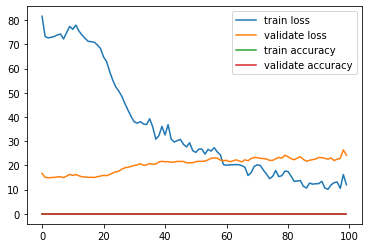

-----
Resnet18_bw TRIPPURP_0
-----
1.5679400404915214 1.3392807208001614 -0.0040915286789047125 -0.004131484918855007
-----


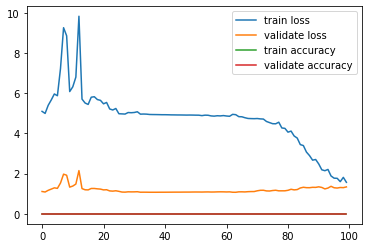

-----
Resnet18_bw TRIPPURP_1
-----
1.1091129016131163 1.737958986312151 -0.006504472032759999 -0.006260428515212234
-----


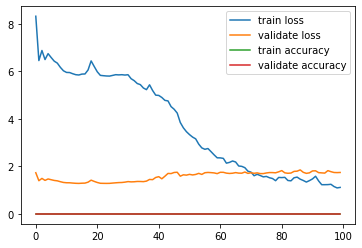

-----
Resnet18_bw TRIPPURP_2
-----
1.2107878390233964 1.1745958868414164 -0.0024651701502092036 -0.0023893859364937193
-----


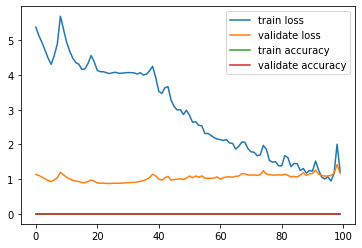

<Figure size 432x288 with 0 Axes>

In [23]:
for row_name,col_name,train_losses,validate_losses,train_accuracies,validate_accuracies in for_plotting:
    results.loc[row_name][col_name] = train_losses[-1],validate_losses[-1],train_accuracies[-1],validate_accuracies[-1]
    print("-----")
    print(row_name, col_name)
    print("-----")
    print(train_losses[-1],validate_losses[-1],train_accuracies[-1],validate_accuracies[-1])
    print("-----")
    plt.plot(train_losses, label = "train loss")
    plt.plot(validate_losses, label = "validate loss")
    
    plt.plot(train_accuracies, label = "train accuracy")
    plt.plot(validate_accuracies, label = "validate accuracy")
    plt.legend()
    plt.show()
    plt.clf()

In [24]:
for_plotting = []

In [25]:
#%%capture output
for row_name in temp:
    for col_name in temp_vars:
        print("------")
        print(row_name, col_name)
        print("------")
        K = 1
        if row_name == "Old_CNN_bw":
            cnn_net = Old_CNN_bw(K).float().to(device)
            image_array = image_array_bw
            
        elif row_name == "Old_CNN_color":
            cnn_net = Old_CNN_color(K).float().to(device)
            image_array = image_array_color
            
        elif row_name == "Resnet18_bw":
            model_ft = torchvision.models.resnet18(pretrained=False)
            for param in model_ft.parameters():
                param.requires_grad = True
            model_ft.conv1 = Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            
            
            image_array = image_array_bw
            
        elif row_name == "Resnet18_color":
            model_ft = torchvision.models.resnet18(pretrained=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            image_array = image_array_color
        
        optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        n_epoches = 100 # To-Do: need more epoches.
        batch_size = 200
        #K = 1 here because we are doing regression, so the final layer output should have size 1
        
        
        y_train = labels_train[col_name].values.reshape(-1,1)
        y_test = labels_test[col_name].values.reshape(-1,1)
        
        training(image_array, x_id_train, y_train, x_id_test, y_test, 
                 cnn_net, optim, criterion, row_name, col_name, n_epochs = 100, batch_size = 200)
        print("*********")
        print(for_plotting)
        print("*********")
        
        #torch.cuda.empty_cache()

------
Resnet18_bw TRIPPURP_3
------
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 6.917344965040684
Epoch 0: train accuracy: -0.0031594463586950418
Epoch 0: validate loss: 1.330554235726595
Epoch 0: validate accuracy: -0.003188653650093755
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 7.543245252221823
Epoch 5: train accuracy: -0.0031594463586950418
Epoch 5: validate loss: 1.487152360379696
Epoch 5: validate accuracy: -0.003188653650093755
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 7.198247484862804
Epoch 10: train accuracy: -0.0031594463586950418
Epoch 10: validate loss: 1.3655985854566097
Epoch 10: validate accuracy: -0.003188653650093755
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 6.22889618575573
Epoch 15: train accuracy: -0.0031594463586950418
Epoch 15: validate loss: 1.1824837177991867
Epoch 15: validate accuracy: -0.003188653650093755
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 6.280149050056934
Epoch 20: train accuracy: -0.0031594463586950418
Epoch 20: validate loss: 1.1968895699828863
Epoch 20: validate accuracy: -0.003188653650093755
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 6.303086914122105
Epoch 25: train accuracy: -0.0031594463586950418
Epoch 25: validate loss: 1.203116400167346
Epoch 25: validate accuracy: -0.003188653650093755
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 6.27914909273386
Epoch 30: train accuracy: -0.0031594463586950418
Epoch 30: validate loss: 1.2119530495256186
Epoch 30: validate accuracy: -0.003188653650093755
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 6.19332698918879
Epoch 35: train accuracy: -0.0031594463586950418
Epoch 35: validate loss: 1.1921117678284645
Epoch 35: validate accuracy: -0.003188653650093755
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 6.1676736660301685
Epoch 40: train accuracy: -0.0031594463586950418
Epoch 40: validate loss: 1.178237808868289
Epoch 40: validate accuracy: -0.003188653650093755
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 6.11034794151783
Epoch 45: train accuracy: -0.0031594463586950418
Epoch 45: validate loss: 1.175220487639308
Epoch 45: validate accuracy: -0.003188653650093755
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 6.143578860908747
Epoch 50: train accuracy: -0.0031594463586950418
Epoch 50: validate loss: 1.1701706852763891
Epoch 50: validate accuracy: -0.003188653650093755
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 6.141353318467736
Epoch 55: train accuracy: -0.0031594463586950418
Epoch 55: validate loss: 1.1711334120482206
Epoch 55: validate accuracy: -0.003188653650093755
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 6.0328907165676355
Epoch 60: train accuracy: -0.0031594463586950418
Epoch 60: validate loss: 1.1766959242522717
Epoch 60: validate accuracy: -0.003188653650093755
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 5.500415842980146
Epoch 65: train accuracy: -0.0031594463586950418
Epoch 65: validate loss: 1.1822130363434553
Epoch 65: validate accuracy: -0.003188653650093755
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 4.434627931565046
Epoch 70: train accuracy: -0.0031594463586950418
Epoch 70: validate loss: 1.2654255367815495
Epoch 70: validate accuracy: -0.003188653650093755
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 3.3383625224232674
Epoch 75: train accuracy: -0.0031594463586950418
Epoch 75: validate loss: 1.4512400850653648
Epoch 75: validate accuracy: -0.003188653650093755
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 2.7479604557156563
Epoch 80: train accuracy: -0.0031594463586950418
Epoch 80: validate loss: 1.5977467931807041
Epoch 80: validate accuracy: -0.003188653650093755
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 2.043725866358727
Epoch 85: train accuracy: -0.0031594463586950418
Epoch 85: validate loss: 1.6636835299432278
Epoch 85: validate accuracy: -0.003188653650093755
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.569735660450533
Epoch 90: train accuracy: -0.0031594463586950418
Epoch 90: validate loss: 1.6146291010081768
Epoch 90: validate accuracy: -0.003188653650093755
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.4931610643398017
Epoch 95: train accuracy: -0.0031594463586950418
Epoch 95: validate loss: 1.7112488150596619
Epoch 95: validate accuracy: -0.003188653650093755
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 1.4874954145634547
Epoch 99: train accuracy: -0.0031594463586950418
Epoch 99: validate loss: 1.5891557522118092
Epoch 99: validate accuracy: -0.003188653650093755
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.173849066719

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 5.5664848536252975
Epoch 0: train accuracy: -0.012684891499088908
Epoch 0: validate loss: 1.1556969732046127
Epoch 0: validate accuracy: -0.012945609344295532
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 5.889630481600761
Epoch 5: train accuracy: -0.012684891499088908
Epoch 5: validate loss: 1.2350410744547844
Epoch 5: validate accuracy: -0.012945609344295532
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 5.499539628624916
Epoch 10: train accuracy: -0.012684891499088908
Epoch 10: validate loss: 1.1431394517421722
Epoch 10: validate accuracy: -0.012945609344295532
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.5312888361513615
Epoch 15: train accuracy: -0.012684891499088908
Epoch 15: validate loss: 1.152709349989891
Epoch 15: validate accuracy: -0.012945609344295532
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 6.100043214857578
Epoch 20: train accuracy: -0.012684891499088908
Epoch 20: validate loss: 1.2605900838971138
Epoch 20: validate accuracy: -0.012945609344295532
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 5.495997779071331
Epoch 25: train accuracy: -0.012684891499088908
Epoch 25: validate loss: 1.147888757288456
Epoch 25: validate accuracy: -0.012945609344295532
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 5.511745322495699
Epoch 30: train accuracy: -0.012684891499088908
Epoch 30: validate loss: 1.1534305661916733
Epoch 30: validate accuracy: -0.012945609344295532
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 5.399653576314449
Epoch 35: train accuracy: -0.012684891499088908
Epoch 35: validate loss: 1.1337779983878136
Epoch 35: validate accuracy: -0.012945609344295532
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 5.4281613137573
Epoch 40: train accuracy: -0.012684891499088908
Epoch 40: validate loss: 1.1829136684536934
Epoch 40: validate accuracy: -0.012945609344295532
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 5.352003399282694
Epoch 45: train accuracy: -0.012684891499088908
Epoch 45: validate loss: 1.1368746422231197
Epoch 45: validate accuracy: -0.012945609344295532
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 5.273543702438474
Epoch 50: train accuracy: -0.012684891499088908
Epoch 50: validate loss: 1.1352400556206703
Epoch 50: validate accuracy: -0.012945609344295532
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 4.751025995239615
Epoch 55: train accuracy: -0.012684891499088908
Epoch 55: validate loss: 1.2249964252114296
Epoch 55: validate accuracy: -0.012945609344295532
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 4.280645840801299
Epoch 60: train accuracy: -0.012684891499088908
Epoch 60: validate loss: 1.3442400358617306
Epoch 60: validate accuracy: -0.012945609344295532
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 3.8766084695234895
Epoch 65: train accuracy: -0.012684891499088908
Epoch 65: validate loss: 1.4846307374536991
Epoch 65: validate accuracy: -0.012945609344295532
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 3.6197575787082314
Epoch 70: train accuracy: -0.012684891499088908
Epoch 70: validate loss: 1.4565988928079605
Epoch 70: validate accuracy: -0.012945609344295532
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 3.0504279835149646
Epoch 75: train accuracy: -0.012684891499088908
Epoch 75: validate loss: 1.5601691864430904
Epoch 75: validate accuracy: -0.012945609344295532
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 2.3959052725695074
Epoch 80: train accuracy: -0.012684891499088908
Epoch 80: validate loss: 1.502537626773119
Epoch 80: validate accuracy: -0.012945609344295532
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.961977259721607
Epoch 85: train accuracy: -0.012684891499088908
Epoch 85: validate loss: 1.473826315253973
Epoch 85: validate accuracy: -0.012945609344295532
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.6153977495850995
Epoch 90: train accuracy: -0.012684891499088908
Epoch 90: validate loss: 1.5276660695672035
Epoch 90: validate accuracy: -0.012945609344295532
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.3799018987920135
Epoch 95: train accuracy: -0.012684891499088908
Epoch 95: validate loss: 1.5272464007139206
Epoch 95: validate accuracy: -0.012945609344295532
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 1.564678215305321
Epoch 99: train accuracy: -0.012684891499088908
Epoch 99: validate loss: 1.5709446519613266
Epoch 99: validate accuracy: -0.012945609344295532
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.17384906671941

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 5.892003794200718
Epoch 0: train accuracy: -0.0011897044786947824
Epoch 0: validate loss: 1.1120747178792953
Epoch 0: validate accuracy: -0.0011325956886603736
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 4.405232671648264
Epoch 5: train accuracy: -0.0011897044786947824
Epoch 5: validate loss: 0.8594171702861786
Epoch 5: validate accuracy: -0.0011325956886603736
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 5.175804135389626
Epoch 10: train accuracy: -0.0011897044786947824
Epoch 10: validate loss: 0.9887888710945845
Epoch 10: validate accuracy: -0.0011325956886603736
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.47644024156034
Epoch 15: train accuracy: -0.0011897044786947824
Epoch 15: validate loss: 1.0475815553218126
Epoch 15: validate accuracy: -0.0011325956886603736
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 5.154916106723249
Epoch 20: train accuracy: -0.0011897044786947824
Epoch 20: validate loss: 0.9849639758467674
Epoch 20: validate accuracy: -0.0011325956886603736
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 4.336479931138456
Epoch 25: train accuracy: -0.0011897044786947824
Epoch 25: validate loss: 0.8322418015450239
Epoch 25: validate accuracy: -0.0011325956886603736
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 4.269539191387594
Epoch 30: train accuracy: -0.0011897044786947824
Epoch 30: validate loss: 0.8263966087251902
Epoch 30: validate accuracy: -0.0011325956886603736
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 4.217253043316305
Epoch 35: train accuracy: -0.0011897044786947824
Epoch 35: validate loss: 0.8323828764259815
Epoch 35: validate accuracy: -0.0011325956886603736
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 3.9672254538163543
Epoch 40: train accuracy: -0.0011897044786947824
Epoch 40: validate loss: 0.8398250695317984
Epoch 40: validate accuracy: -0.0011325956886603736
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 3.924625774845481
Epoch 45: train accuracy: -0.0011897044786947824
Epoch 45: validate loss: 0.8571876883506775
Epoch 45: validate accuracy: -0.0011325956886603736
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 3.8007251769304276
Epoch 50: train accuracy: -0.0011897044786947824
Epoch 50: validate loss: 0.9348183199763298
Epoch 50: validate accuracy: -0.0011325956886603736
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 3.036795422900468
Epoch 55: train accuracy: -0.0011897044786947824
Epoch 55: validate loss: 0.9151089284569025
Epoch 55: validate accuracy: -0.0011325956886603736
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 2.69008893892169
Epoch 60: train accuracy: -0.0011897044786947824
Epoch 60: validate loss: 0.9986141789704561
Epoch 60: validate accuracy: -0.0011325956886603736
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 2.231707403669134
Epoch 65: train accuracy: -0.0011897044786947824
Epoch 65: validate loss: 0.952522024512291
Epoch 65: validate accuracy: -0.0011325956886603736
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.6878285338170826
Epoch 70: train accuracy: -0.0011897044786947824
Epoch 70: validate loss: 0.910198787227273
Epoch 70: validate accuracy: -0.0011325956886603736
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.5576232050079852
Epoch 75: train accuracy: -0.0011897044786947824
Epoch 75: validate loss: 0.9300014674663544
Epoch 75: validate accuracy: -0.0011325956886603736
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.2375758145935833
Epoch 80: train accuracy: -0.0011897044786947824
Epoch 80: validate loss: 0.934868598356843
Epoch 80: validate accuracy: -0.0011325956886603736
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.2324136801762506
Epoch 85: train accuracy: -0.0011897044786947824
Epoch 85: validate loss: 0.9218788035213947
Epoch 85: validate accuracy: -0.0011325956886603736
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.1002822509035468
Epoch 90: train accuracy: -0.0011897044786947824
Epoch 90: validate loss: 0.9382742587476969
Epoch 90: validate accuracy: -0.0011325956886603736
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.9657805956667289
Epoch 95: train accuracy: -0.0011897044786947824
Epoch 95: validate loss: 0.9649639502167702
Epoch 95: validate accuracy: -0.0011325956886603736
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 0.8715231932001188
Epoch 99: train accuracy: -0.0011897044786947824
Epoch 99: validate loss: 0.9516336359083652
Epoch 99: validate accuracy: -0.0011325956886603736
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.17384906671

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 18.485077783465385
Epoch 0: train accuracy: -0.008898592927181285
Epoch 0: validate loss: 3.953652434051037
Epoch 0: validate accuracy: -0.00889476579723966
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 20.28264919668436
Epoch 5: train accuracy: -0.008898592927181285
Epoch 5: validate loss: 4.268975108861923
Epoch 5: validate accuracy: -0.00889476579723966
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 20.445706583559513
Epoch 10: train accuracy: -0.008898592927181285
Epoch 10: validate loss: 4.296878829598427
Epoch 10: validate accuracy: -0.00889476579723966
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 18.512933313846588
Epoch 15: train accuracy: -0.008898592927181285
Epoch 15: validate loss: 3.9143496081233025
Epoch 15: validate accuracy: -0.00889476579723966
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 17.22875153273344
Epoch 20: train accuracy: -0.008898592927181285
Epoch 20: validate loss: 3.686720721423626
Epoch 20: validate accuracy: -0.00889476579723966
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 16.49464574456215
Epoch 25: train accuracy: -0.008898592927181285
Epoch 25: validate loss: 3.6185904070734978
Epoch 25: validate accuracy: -0.00889476579723966
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 15.495632193982601
Epoch 30: train accuracy: -0.008898592927181285
Epoch 30: validate loss: 3.8358887135982513
Epoch 30: validate accuracy: -0.00889476579723966
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 13.899668347090483
Epoch 35: train accuracy: -0.008898592927181285
Epoch 35: validate loss: 4.275181956589222
Epoch 35: validate accuracy: -0.00889476579723966
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 12.293154306709766
Epoch 40: train accuracy: -0.008898592927181285
Epoch 40: validate loss: 4.6219843327999115
Epoch 40: validate accuracy: -0.00889476579723966
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 10.936462134122849
Epoch 45: train accuracy: -0.008898592927181285
Epoch 45: validate loss: 5.010267689824104
Epoch 45: validate accuracy: -0.00889476579723966
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 9.920051855966449
Epoch 50: train accuracy: -0.008898592927181285
Epoch 50: validate loss: 5.01792511343956
Epoch 50: validate accuracy: -0.00889476579723966
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 7.677555212751031
Epoch 55: train accuracy: -0.008898592927181285
Epoch 55: validate loss: 5.187853991985321
Epoch 55: validate accuracy: -0.00889476579723966
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 6.489596605300903
Epoch 60: train accuracy: -0.008898592927181285
Epoch 60: validate loss: 5.203617542982101
Epoch 60: validate accuracy: -0.00889476579723966
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 5.359971027821302
Epoch 65: train accuracy: -0.008898592927181285
Epoch 65: validate loss: 5.403994038701057
Epoch 65: validate accuracy: -0.00889476579723966
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 4.9238396836444736
Epoch 70: train accuracy: -0.008898592927181285
Epoch 70: validate loss: 5.328799366950989
Epoch 70: validate accuracy: -0.00889476579723966
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 5.342630779836327
Epoch 75: train accuracy: -0.008898592927181285
Epoch 75: validate loss: 5.27482995390892
Epoch 75: validate accuracy: -0.00889476579723966
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 4.395327646518126
Epoch 80: train accuracy: -0.008898592927181285
Epoch 80: validate loss: 5.444253355264664
Epoch 80: validate accuracy: -0.00889476579723966
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 4.751900136936456
Epoch 85: train accuracy: -0.008898592927181285
Epoch 85: validate loss: 5.175899311900139
Epoch 85: validate accuracy: -0.00889476579723966
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 3.2613925768528134
Epoch 90: train accuracy: -0.008898592927181285
Epoch 90: validate loss: 5.432512506842613
Epoch 90: validate accuracy: -0.00889476579723966
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 3.4782601797487587
Epoch 95: train accuracy: -0.008898592927181285
Epoch 95: validate loss: 5.442862913012505
Epoch 95: validate accuracy: -0.00889476579723966
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 3.004494822351262
Epoch 99: train accuracy: -0.008898592927181285
Epoch 99: validate loss: 5.456847086548805
Epoch 99: validate accuracy: -0.00889476579723966
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.173849066719413,

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 17.148234710097313
Epoch 0: train accuracy: -0.003198388791955348
Epoch 0: validate loss: 3.450405791401863
Epoch 0: validate accuracy: -0.0030229213404769097
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 17.094256922602654
Epoch 5: train accuracy: -0.003198388791955348
Epoch 5: validate loss: 3.436500981450081
Epoch 5: validate accuracy: -0.0030229213404769097
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 13.18478299677372
Epoch 10: train accuracy: -0.003198388791955348
Epoch 10: validate loss: 2.697484567761421
Epoch 10: validate accuracy: -0.0030229213404769097
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 13.105197757482529
Epoch 15: train accuracy: -0.003198388791955348
Epoch 15: validate loss: 2.6897647380828857
Epoch 15: validate accuracy: -0.0030229213404769097
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 12.834924347698689
Epoch 20: train accuracy: -0.003198388791955348
Epoch 20: validate loss: 2.642600528895855
Epoch 20: validate accuracy: -0.0030229213404769097
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 12.1391381919384
Epoch 25: train accuracy: -0.003198388791955348
Epoch 25: validate loss: 2.5421758219599724
Epoch 25: validate accuracy: -0.0030229213404769097
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 12.00525402650237
Epoch 30: train accuracy: -0.003198388791955348
Epoch 30: validate loss: 2.5823875591158867
Epoch 30: validate accuracy: -0.0030229213404769097
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 12.113388728350401
Epoch 35: train accuracy: -0.003198388791955348
Epoch 35: validate loss: 2.7763786762952805
Epoch 35: validate accuracy: -0.0030229213404769097
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 11.640527354553342
Epoch 40: train accuracy: -0.003198388791955348
Epoch 40: validate loss: 2.942900240421295
Epoch 40: validate accuracy: -0.0030229213404769097
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 9.948054887354374
Epoch 45: train accuracy: -0.003198388791955348
Epoch 45: validate loss: 3.127762883901596
Epoch 45: validate accuracy: -0.0030229213404769097
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 9.13391849398613
Epoch 50: train accuracy: -0.003198388791955348
Epoch 50: validate loss: 3.170803487300873
Epoch 50: validate accuracy: -0.0030229213404769097
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 6.291487453505397
Epoch 55: train accuracy: -0.003198388791955348
Epoch 55: validate loss: 3.3489109873771667
Epoch 55: validate accuracy: -0.0030229213404769097
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 4.634073824621737
Epoch 60: train accuracy: -0.003198388791955348
Epoch 60: validate loss: 3.4424047246575356
Epoch 60: validate accuracy: -0.0030229213404769097
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 4.271534353494644
Epoch 65: train accuracy: -0.003198388791955348
Epoch 65: validate loss: 3.2841540724039078
Epoch 65: validate accuracy: -0.0030229213404769097
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 3.558435988612473
Epoch 70: train accuracy: -0.003198388791955348
Epoch 70: validate loss: 3.642374575138092
Epoch 70: validate accuracy: -0.0030229213404769097
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 3.2212350838817656
Epoch 75: train accuracy: -0.003198388791955348
Epoch 75: validate loss: 3.5856222361326218
Epoch 75: validate accuracy: -0.0030229213404769097
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 3.206477468367666
Epoch 80: train accuracy: -0.003198388791955348
Epoch 80: validate loss: 3.7914800345897675
Epoch 80: validate accuracy: -0.0030229213404769097
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 2.687193090096116
Epoch 85: train accuracy: -0.003198388791955348
Epoch 85: validate loss: 3.6221666485071182
Epoch 85: validate accuracy: -0.0030229213404769097
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 3.683001541532576
Epoch 90: train accuracy: -0.003198388791955348
Epoch 90: validate loss: 3.539466954767704
Epoch 90: validate accuracy: -0.0030229213404769097
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 2.6076945373788476
Epoch 95: train accuracy: -0.003198388791955348
Epoch 95: validate loss: 4.01577091217041
Epoch 95: validate accuracy: -0.0030229213404769097
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 2.387928698444739
Epoch 99: train accuracy: -0.003198388791955348
Epoch 99: validate loss: 3.930560350418091
Epoch 99: validate accuracy: -0.0030229213404769097
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.17384906671941

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 9.461397275328636
Epoch 0: train accuracy: -0.0021859093663842318
Epoch 0: validate loss: 2.111771535128355
Epoch 0: validate accuracy: -0.0022580719935941275
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 9.625453308224678
Epoch 5: train accuracy: -0.0021859093663842318
Epoch 5: validate loss: 2.1354556642472744
Epoch 5: validate accuracy: -0.0022580719935941275
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 9.377379443496466
Epoch 10: train accuracy: -0.0021859093663842318
Epoch 10: validate loss: 2.0811437144875526
Epoch 10: validate accuracy: -0.0022580719935941275
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 9.655108641833067
Epoch 15: train accuracy: -0.0021859093663842318
Epoch 15: validate loss: 2.132475532591343
Epoch 15: validate accuracy: -0.0022580719935941275
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 9.316423490643501
Epoch 20: train accuracy: -0.0021859093663842318
Epoch 20: validate loss: 2.079226966947317
Epoch 20: validate accuracy: -0.0022580719935941275
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 9.322108712047338
Epoch 25: train accuracy: -0.0021859093663842318
Epoch 25: validate loss: 2.089851025491953
Epoch 25: validate accuracy: -0.0022580719935941275
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 9.22536825761199
Epoch 30: train accuracy: -0.0021859093663842318
Epoch 30: validate loss: 2.1171432584524155
Epoch 30: validate accuracy: -0.0022580719935941275
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 9.238557908684015
Epoch 35: train accuracy: -0.0021859093663842318
Epoch 35: validate loss: 2.0892482548952103
Epoch 35: validate accuracy: -0.0022580719935941275
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 9.275694269686937
Epoch 40: train accuracy: -0.0021859093663842318
Epoch 40: validate loss: 2.0773310773074627
Epoch 40: validate accuracy: -0.0022580719935941275
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 9.287246227264404
Epoch 45: train accuracy: -0.0021859093663842318
Epoch 45: validate loss: 2.0774692595005035
Epoch 45: validate accuracy: -0.0022580719935941275
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 9.058046255260706
Epoch 50: train accuracy: -0.0021859093663842318
Epoch 50: validate loss: 2.079705934971571
Epoch 50: validate accuracy: -0.0022580719935941275
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 7.887345999479294
Epoch 55: train accuracy: -0.0021859093663842318
Epoch 55: validate loss: 2.289382703602314
Epoch 55: validate accuracy: -0.0022580719935941275
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 6.947280321270227
Epoch 60: train accuracy: -0.0021859093663842318
Epoch 60: validate loss: 2.4550265297293663
Epoch 60: validate accuracy: -0.0022580719935941275
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 6.295909019187093
Epoch 65: train accuracy: -0.0021859093663842318
Epoch 65: validate loss: 2.7055809795856476
Epoch 65: validate accuracy: -0.0022580719935941275
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 4.799926993437111
Epoch 70: train accuracy: -0.0021859093663842318
Epoch 70: validate loss: 2.7273513227701187
Epoch 70: validate accuracy: -0.0022580719935941275
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 3.743185443803668
Epoch 75: train accuracy: -0.0021859093663842318
Epoch 75: validate loss: 2.7313526645302773
Epoch 75: validate accuracy: -0.0022580719935941275
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 4.061015701852739
Epoch 80: train accuracy: -0.0021859093663842318
Epoch 80: validate loss: 2.926976300776005
Epoch 80: validate accuracy: -0.0022580719935941275
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 3.7853586114943027
Epoch 85: train accuracy: -0.0021859093663842318
Epoch 85: validate loss: 3.0941505134105682
Epoch 85: validate accuracy: -0.0022580719935941275
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 3.000811079982668
Epoch 90: train accuracy: -0.0021859093663842318
Epoch 90: validate loss: 2.8342559561133385
Epoch 90: validate accuracy: -0.0022580719935941275
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 2.2428138349205256
Epoch 95: train accuracy: -0.0021859093663842318
Epoch 95: validate loss: 2.7519840225577354
Epoch 95: validate accuracy: -0.0022580719935941275
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 2.3661700836382806
Epoch 99: train accuracy: -0.0021859093663842318
Epoch 99: validate loss: 2.910975679755211
Epoch 99: validate accuracy: -0.0022580719935941275
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.173849066719

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 2.0998214492574334
Epoch 0: train accuracy: -0.00033106526757371147
Epoch 0: validate loss: 0.4451543749310076
Epoch 0: validate accuracy: -0.000329090846943703
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.9161678792443126
Epoch 5: train accuracy: -0.00033106526757371147
Epoch 5: validate loss: 0.40877431468106806
Epoch 5: validate accuracy: -0.000329090846943703
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.8792915206868201
Epoch 10: train accuracy: -0.00033106526757371147
Epoch 10: validate loss: 0.4100891426205635
Epoch 10: validate accuracy: -0.000329090846943703
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.9634904091944918
Epoch 15: train accuracy: -0.00033106526757371147
Epoch 15: validate loss: 0.42272558552213013
Epoch 15: validate accuracy: -0.000329090846943703
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.7650143299251795
Epoch 20: train accuracy: -0.00033106526757371147
Epoch 20: validate loss: 0.38466332177631557
Epoch 20: validate accuracy: -0.000329090846943703
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.7184066696790978
Epoch 25: train accuracy: -0.00033106526757371147
Epoch 25: validate loss: 0.37322861899156123
Epoch 25: validate accuracy: -0.000329090846943703
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.7359850746579468
Epoch 30: train accuracy: -0.00033106526757371147
Epoch 30: validate loss: 0.3799546661321074
Epoch 30: validate accuracy: -0.000329090846943703
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.7284533351194113
Epoch 35: train accuracy: -0.00033106526757371147
Epoch 35: validate loss: 0.3739507194259204
Epoch 35: validate accuracy: -0.000329090846943703
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.7197868999792263
Epoch 40: train accuracy: -0.00033106526757371147
Epoch 40: validate loss: 0.3746437297668308
Epoch 40: validate accuracy: -0.000329090846943703
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.6794289792887866
Epoch 45: train accuracy: -0.00033106526757371147
Epoch 45: validate loss: 0.3754405932268128
Epoch 45: validate accuracy: -0.000329090846943703
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.7287885418627411
Epoch 50: train accuracy: -0.00033106526757371147
Epoch 50: validate loss: 0.37382004980463535
Epoch 50: validate accuracy: -0.000329090846943703
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.7227933560498059
Epoch 55: train accuracy: -0.00033106526757371147
Epoch 55: validate loss: 0.37440972891636193
Epoch 55: validate accuracy: -0.000329090846943703
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.6878912883112207
Epoch 60: train accuracy: -0.00033106526757371147
Epoch 60: validate loss: 0.3755888136802241
Epoch 60: validate accuracy: -0.000329090846943703
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.6996557593811303
Epoch 65: train accuracy: -0.00033106526757371147
Epoch 65: validate loss: 0.3746336252661422
Epoch 65: validate accuracy: -0.000329090846943703
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.7192612109938636
Epoch 70: train accuracy: -0.00033106526757371147
Epoch 70: validate loss: 0.37263177905697376
Epoch 70: validate accuracy: -0.000329090846943703
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.7019931465038098
Epoch 75: train accuracy: -0.00033106526757371147
Epoch 75: validate loss: 0.3752167922211811
Epoch 75: validate accuracy: -0.000329090846943703
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.2121731536462903
Epoch 80: train accuracy: -0.00033106526757371147
Epoch 80: validate loss: 0.3893596736015752
Epoch 80: validate accuracy: -0.000329090846943703
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.0080518221948296
Epoch 85: train accuracy: -0.00033106526757371147
Epoch 85: validate loss: 0.39325303462101147
Epoch 85: validate accuracy: -0.000329090846943703
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.9577779385726899
Epoch 90: train accuracy: -0.00033106526757371147
Epoch 90: validate loss: 0.39237826236058027
Epoch 90: validate accuracy: -0.000329090846943703
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.8278870119247586
Epoch 95: train accuracy: -0.00033106526757371147
Epoch 95: validate loss: 0.38911772856954485
Epoch 95: validate accuracy: -0.000329090846943703
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 0.7493828409351408
Epoch 99: train accuracy: -0.00033106526757371147
Epoch 99: validate loss: 0.3946893314132467
Epoch 99: validate accuracy: -0.000329090846943703
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.17384906671

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 2.2506205146200955
Epoch 0: train accuracy: -0.0002843177759690532
Epoch 0: validate loss: 0.4800442149862647
Epoch 0: validate accuracy: -0.0002808020046864036
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.2240618569776416
Epoch 5: train accuracy: -0.0002843177759690532
Epoch 5: validate loss: 0.26357810432091355
Epoch 5: validate accuracy: -0.0002808020046864036
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.1530031957663596
Epoch 10: train accuracy: -0.0002843177759690532
Epoch 10: validate loss: 0.2483119199750945
Epoch 10: validate accuracy: -0.0002808020046864036
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.2857450633309782
Epoch 15: train accuracy: -0.0002843177759690532
Epoch 15: validate loss: 0.27814396540634334
Epoch 15: validate accuracy: -0.0002808020046864036
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.3406198194716126
Epoch 20: train accuracy: -0.0002843177759690532
Epoch 20: validate loss: 0.291828895220533
Epoch 20: validate accuracy: -0.0002808020046864036
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.5914192139171064
Epoch 25: train accuracy: -0.0002843177759690532
Epoch 25: validate loss: 0.34469574643298984
Epoch 25: validate accuracy: -0.0002808020046864036
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.6601324663497508
Epoch 30: train accuracy: -0.0002843177759690532
Epoch 30: validate loss: 0.3615444363094866
Epoch 30: validate accuracy: -0.0002808020046864036
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.340042449068278
Epoch 35: train accuracy: -0.0002843177759690532
Epoch 35: validate loss: 0.2992366834077984
Epoch 35: validate accuracy: -0.0002808020046864036
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 0.935976634034887
Epoch 40: train accuracy: -0.0002843177759690532
Epoch 40: validate loss: 0.23162024072371423
Epoch 40: validate accuracy: -0.0002808020046864036
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 0.9012427512789145
Epoch 45: train accuracy: -0.0002843177759690532
Epoch 45: validate loss: 0.23257757863029838
Epoch 45: validate accuracy: -0.0002808020046864036
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 0.8408973831683397
Epoch 50: train accuracy: -0.0002843177759690532
Epoch 50: validate loss: 0.24303997866809368
Epoch 50: validate accuracy: -0.0002808020046864036
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 0.7727415286353789
Epoch 55: train accuracy: -0.0002843177759690532
Epoch 55: validate loss: 0.2372755233081989
Epoch 55: validate accuracy: -0.0002808020046864036
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 0.7071994928992353
Epoch 60: train accuracy: -0.0002843177759690532
Epoch 60: validate loss: 0.23923057643696666
Epoch 60: validate accuracy: -0.0002808020046864036
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 0.6926079128170386
Epoch 65: train accuracy: -0.0002843177759690532
Epoch 65: validate loss: 0.22824523341841996
Epoch 65: validate accuracy: -0.0002808020046864036
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 0.6552321622148156
Epoch 70: train accuracy: -0.0002843177759690532
Epoch 70: validate loss: 0.23201459809206426
Epoch 70: validate accuracy: -0.0002808020046864036
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.5541163914022036
Epoch 75: train accuracy: -0.0002843177759690532
Epoch 75: validate loss: 0.22258993471041322
Epoch 75: validate accuracy: -0.0002808020046864036
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.5571278274292126
Epoch 80: train accuracy: -0.0002843177759690532
Epoch 80: validate loss: 0.2285950599471107
Epoch 80: validate accuracy: -0.0002808020046864036
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.5666742532048374
Epoch 85: train accuracy: -0.0002843177759690532
Epoch 85: validate loss: 0.2259147787699476
Epoch 85: validate accuracy: -0.0002808020046864036
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.5081609855988063
Epoch 90: train accuracy: -0.0002843177759690532
Epoch 90: validate loss: 0.22923649370204657
Epoch 90: validate accuracy: -0.0002808020046864036
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.4664898886694573
Epoch 95: train accuracy: -0.0002843177759690532
Epoch 95: validate loss: 0.23126963851973414
Epoch 95: validate accuracy: -0.0002808020046864036
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 0.45046340400585905
Epoch 99: train accuracy: -0.0002843177759690532
Epoch 99: validate loss: 0.23206739872694016
Epoch 99: validate accuracy: -0.0002808020046864036
*********
[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.173849066

In [26]:
print(for_plotting)

[('Resnet18_bw', 'TRIPPURP_3', [6.917344965040684, 6.746388126164675, 6.541566234081984, 6.830297406762838, 7.567179527133703, 7.543245252221823, 6.741312477737665, 6.212809380143881, 6.3727751690894365, 6.178100883960724, 7.198247484862804, 6.190735101699829, 7.537934303283691, 7.14097448810935, 6.424604631960392, 6.22889618575573, 6.192805232480168, 6.182298664003611, 6.314952647313476, 6.559563905000687, 6.280149050056934, 6.316642278805375, 6.374713348224759, 6.542602032423019, 6.755859576165676, 6.303086914122105, 6.548881534487009, 6.246196614578366, 6.252384398132563, 6.267427448183298, 6.27914909273386, 6.251439783722162, 6.199565581977367, 6.203941842541099, 6.188473850488663, 6.19332698918879, 6.414653414860368, 6.253700630739331, 6.234256794676185, 6.173849066719413, 6.1676736660301685, 6.1273004449903965, 6.124333592131734, 6.087158871814609, 6.090301809832454, 6.11034794151783, 6.115587303414941, 6.131366008892655, 6.09603975340724, 6.155723070725799, 6.143578860908747, 6.

In [28]:
temp = ["Resnet18_color"]

In [29]:
for_plotting = []

In [30]:
#%%capture output
for row_name in temp:
    for col_name in dependent_variables:
        print("------")
        print(row_name, col_name)
        print("------")
        K = 1
        if row_name == "Old_CNN_bw":
            cnn_net = Old_CNN_bw(K).float().to(device)
            image_array = image_array_bw
            
        elif row_name == "Old_CNN_color":
            cnn_net = Old_CNN_color(K).float().to(device)
            image_array = image_array_color
            
        elif row_name == "Resnet18_bw":
            model_ft = torchvision.models.resnet18(pretrained=False)
            for param in model_ft.parameters():
                param.requires_grad = True
            model_ft.conv1 = Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            
            
            image_array = image_array_bw
            
        elif row_name == "Resnet18_color":
            model_ft = torchvision.models.resnet18(pretrained=False)
            num_ftrs = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_ftrs, K, bias = True)
            cnn_net = model_ft.float().to(device)
            image_array = image_array_color
        
        optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        n_epoches = 100 # To-Do: need more epoches.
        batch_size = 200
        #K = 1 here because we are doing regression, so the final layer output should have size 1
        
        
        y_train = labels_train[col_name].values.reshape(-1,1)
        y_test = labels_test[col_name].values.reshape(-1,1)
        
        training(image_array, x_id_train, y_train, x_id_test, y_test, 
                 cnn_net, optim, criterion, row_name, col_name, n_epochs = 100, batch_size = 200)
        print("*********")
        print(for_plotting)
        print("*********")
        
        #torch.cuda.empty_cache()

------
Resnet18_color HHVEHCNT
------
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 73.36728748679161
Epoch 0: train accuracy: -0.03458188741872873
Epoch 0: validate loss: 15.049890637397766
Epoch 0: validate accuracy: -0.03463212978995565
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 73.70512101054192
Epoch 5: train accuracy: -0.03458188741872873
Epoch 5: validate loss: 15.19081535935402
Epoch 5: validate accuracy: -0.03463212978995565
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 74.82190158963203
Epoch 10: train accuracy: -0.03458188741872873
Epoch 10: validate loss: 15.292276322841644
Epoch 10: validate accuracy: -0.03463212978995565
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 72.97460097074509
Epoch 15: train accuracy: -0.03458188741872873
Epoch 15: validate loss: 15.100810676813126
Epoch 15: validate accuracy: -0.03463212978995565
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 72.0869788825512
Epoch 20: train accuracy: -0.03458188741872873
Epoch 20: validate loss: 14.9617260992527
Epoch 20: validate accuracy: -0.03463212978995565
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 71.96282467246056
Epoch 25: train accuracy: -0.03458188741872873
Epoch 25: validate loss: 14.96782785654068
Epoch 25: validate accuracy: -0.03463212978995565
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 72.25319293141365
Epoch 30: train accuracy: -0.03458188741872873
Epoch 30: validate loss: 14.937070280313492
Epoch 30: validate accuracy: -0.03463212978995565
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 70.69413179159164
Epoch 35: train accuracy: -0.03458188741872873
Epoch 35: validate loss: 15.380365818738937
Epoch 35: validate accuracy: -0.03463212978995565
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 62.78461502864957
Epoch 40: train accuracy: -0.03458188741872873
Epoch 40: validate loss: 17.086873412132263
Epoch 40: validate accuracy: -0.03463212978995565
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 51.221624597907066
Epoch 45: train accuracy: -0.03458188741872873
Epoch 45: validate loss: 17.916656643152237
Epoch 45: validate accuracy: -0.03463212978995565
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 42.84553726762533
Epoch 50: train accuracy: -0.03458188741872873
Epoch 50: validate loss: 21.210817635059357
Epoch 50: validate accuracy: -0.03463212978995565
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 31.97735434398055
Epoch 55: train accuracy: -0.03458188741872873
Epoch 55: validate loss: 21.2437584400177
Epoch 55: validate accuracy: -0.03463212978995565
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 23.47689868323505
Epoch 60: train accuracy: -0.03458188741872873
Epoch 60: validate loss: 21.938540756702423
Epoch 60: validate accuracy: -0.03463212978995565
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 19.546199943870306
Epoch 65: train accuracy: -0.03458188741872873
Epoch 65: validate loss: 20.88942050933838
Epoch 65: validate accuracy: -0.03463212978995565
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 17.523607990238816
Epoch 70: train accuracy: -0.03458188741872873
Epoch 70: validate loss: 21.013384580612183
Epoch 70: validate accuracy: -0.03463212978995565
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 14.818026335909963
Epoch 75: train accuracy: -0.03458188741872873
Epoch 75: validate loss: 20.944334387779236
Epoch 75: validate accuracy: -0.03463212978995565
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 11.512242098804563
Epoch 80: train accuracy: -0.03458188741872873
Epoch 80: validate loss: 20.881927967071533
Epoch 80: validate accuracy: -0.03463212978995565
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 11.073358715511858
Epoch 85: train accuracy: -0.03458188741872873
Epoch 85: validate loss: 20.32404339313507
Epoch 85: validate accuracy: -0.03463212978995565
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 9.041061656083912
Epoch 90: train accuracy: -0.03458188741872873
Epoch 90: validate loss: 20.37859410047531
Epoch 90: validate accuracy: -0.03463212978995565
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 8.068558860570192
Epoch 95: train accuracy: -0.03458188741872873
Epoch 95: validate loss: 20.039820849895477
Epoch 95: validate accuracy: -0.03463212978995565
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 8.193057627417147
Epoch 99: train accuracy: -0.03458188741872873
Epoch 99: validate loss: 20.16099226474762
Epoch 99: validate accuracy: -0.03463212978995565
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.03254856169224, 

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 5.457112669944763
Epoch 0: train accuracy: -0.0040915286789047125
Epoch 0: validate loss: 1.183099264279008
Epoch 0: validate accuracy: -0.004131484918855007
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 5.132119629532099
Epoch 5: train accuracy: -0.0040915286789047125
Epoch 5: validate loss: 1.1117182560265064
Epoch 5: validate accuracy: -0.004131484918855007
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 5.1604179590940475
Epoch 10: train accuracy: -0.0040915286789047125
Epoch 10: validate loss: 1.1133176945149899
Epoch 10: validate accuracy: -0.004131484918855007
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.059862634167075
Epoch 15: train accuracy: -0.0040915286789047125
Epoch 15: validate loss: 1.0972362775355577
Epoch 15: validate accuracy: -0.004131484918855007
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 5.114340493455529
Epoch 20: train accuracy: -0.0040915286789047125
Epoch 20: validate loss: 1.1279204096645117
Epoch 20: validate accuracy: -0.004131484918855007
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 5.027575254440308
Epoch 25: train accuracy: -0.0040915286789047125
Epoch 25: validate loss: 1.103578431531787
Epoch 25: validate accuracy: -0.004131484918855007
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 4.914831163361669
Epoch 30: train accuracy: -0.0040915286789047125
Epoch 30: validate loss: 1.1159029826521873
Epoch 30: validate accuracy: -0.004131484918855007
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 4.783055836334825
Epoch 35: train accuracy: -0.0040915286789047125
Epoch 35: validate loss: 1.1408862620592117
Epoch 35: validate accuracy: -0.004131484918855007
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 4.685159474611282
Epoch 40: train accuracy: -0.0040915286789047125
Epoch 40: validate loss: 1.190944155678153
Epoch 40: validate accuracy: -0.004131484918855007
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 4.398743079043925
Epoch 45: train accuracy: -0.0040915286789047125
Epoch 45: validate loss: 1.1186417005956173
Epoch 45: validate accuracy: -0.004131484918855007
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 3.916510432958603
Epoch 50: train accuracy: -0.0040915286789047125
Epoch 50: validate loss: 1.1686505693942308
Epoch 50: validate accuracy: -0.004131484918855007
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 3.1943050930276513
Epoch 55: train accuracy: -0.0040915286789047125
Epoch 55: validate loss: 1.3228710945695639
Epoch 55: validate accuracy: -0.004131484918855007
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 2.41880469257012
Epoch 60: train accuracy: -0.0040915286789047125
Epoch 60: validate loss: 1.3812857549637556
Epoch 60: validate accuracy: -0.004131484918855007
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.9126762468367815
Epoch 65: train accuracy: -0.0040915286789047125
Epoch 65: validate loss: 1.5095802731812
Epoch 65: validate accuracy: -0.004131484918855007
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.536443140823394
Epoch 70: train accuracy: -0.0040915286789047125
Epoch 70: validate loss: 1.534260906279087
Epoch 70: validate accuracy: -0.004131484918855007
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.0614185659214854
Epoch 75: train accuracy: -0.0040915286789047125
Epoch 75: validate loss: 1.4179844111204147
Epoch 75: validate accuracy: -0.004131484918855007
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.0037708433228545
Epoch 80: train accuracy: -0.0040915286789047125
Epoch 80: validate loss: 1.467297337949276
Epoch 80: validate accuracy: -0.004131484918855007
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.736161306471331
Epoch 85: train accuracy: -0.0040915286789047125
Epoch 85: validate loss: 1.4096305817365646
Epoch 85: validate accuracy: -0.004131484918855007
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.8812772280070931
Epoch 90: train accuracy: -0.0040915286789047125
Epoch 90: validate loss: 1.3455599807202816
Epoch 90: validate accuracy: -0.004131484918855007
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.6309247369645163
Epoch 95: train accuracy: -0.0040915286789047125
Epoch 95: validate loss: 1.3590786792337894
Epoch 95: validate accuracy: -0.004131484918855007
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 0.5188978250080254
Epoch 99: train accuracy: -0.0040915286789047125
Epoch 99: validate loss: 1.3608262687921524
Epoch 99: validate accuracy: -0.004131484918855007
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.03254856169

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 6.007465269416571
Epoch 0: train accuracy: -0.006504472032759999
Epoch 0: validate loss: 1.3018872775137424
Epoch 0: validate accuracy: -0.006260428515212234
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 7.549056030809879
Epoch 5: train accuracy: -0.006504472032759999
Epoch 5: validate loss: 1.6429663188755512
Epoch 5: validate accuracy: -0.006260428515212234
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 6.006055902689695
Epoch 10: train accuracy: -0.006504472032759999
Epoch 10: validate loss: 1.3159823901951313
Epoch 10: validate accuracy: -0.006260428515212234
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.960627654567361
Epoch 15: train accuracy: -0.006504472032759999
Epoch 15: validate loss: 1.3012805730104446
Epoch 15: validate accuracy: -0.006260428515212234
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 5.870103929191828
Epoch 20: train accuracy: -0.006504472032759999
Epoch 20: validate loss: 1.2789795473217964
Epoch 20: validate accuracy: -0.006260428515212234
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 6.638912592083216
Epoch 25: train accuracy: -0.006504472032759999
Epoch 25: validate loss: 1.4663777388632298
Epoch 25: validate accuracy: -0.006260428515212234
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 5.8889424726367
Epoch 30: train accuracy: -0.006504472032759999
Epoch 30: validate loss: 1.295277040451765
Epoch 30: validate accuracy: -0.006260428515212234
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 5.832996292039752
Epoch 35: train accuracy: -0.006504472032759999
Epoch 35: validate loss: 1.277010913938284
Epoch 35: validate accuracy: -0.006260428515212234
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 6.053222231566906
Epoch 40: train accuracy: -0.006504472032759999
Epoch 40: validate loss: 1.3144116625189781
Epoch 40: validate accuracy: -0.006260428515212234
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 5.876961518079042
Epoch 45: train accuracy: -0.006504472032759999
Epoch 45: validate loss: 1.2798166126012802
Epoch 45: validate accuracy: -0.006260428515212234
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 5.843489656224847
Epoch 50: train accuracy: -0.006504472032759999
Epoch 50: validate loss: 1.2742167189717293
Epoch 50: validate accuracy: -0.006260428515212234
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 5.839014992117882
Epoch 55: train accuracy: -0.006504472032759999
Epoch 55: validate loss: 1.2744532972574234
Epoch 55: validate accuracy: -0.006260428515212234
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 5.831360327079892
Epoch 60: train accuracy: -0.006504472032759999
Epoch 60: validate loss: 1.274665754288435
Epoch 60: validate accuracy: -0.006260428515212234
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 5.8297583274543285
Epoch 65: train accuracy: -0.006504472032759999
Epoch 65: validate loss: 1.2753993347287178
Epoch 65: validate accuracy: -0.006260428515212234
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 5.823758840560913
Epoch 70: train accuracy: -0.006504472032759999
Epoch 70: validate loss: 1.275878768414259
Epoch 70: validate accuracy: -0.006260428515212234
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 5.816170120611787
Epoch 75: train accuracy: -0.006504472032759999
Epoch 75: validate loss: 1.2754020392894745
Epoch 75: validate accuracy: -0.006260428515212234
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 5.823910670354962
Epoch 80: train accuracy: -0.006504472032759999
Epoch 80: validate loss: 1.2800675630569458
Epoch 80: validate accuracy: -0.006260428515212234
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 5.798266217112541
Epoch 85: train accuracy: -0.006504472032759999
Epoch 85: validate loss: 1.276028849184513
Epoch 85: validate accuracy: -0.006260428515212234
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 5.792584411799908
Epoch 90: train accuracy: -0.006504472032759999
Epoch 90: validate loss: 1.2772991955280304
Epoch 90: validate accuracy: -0.006260428515212234
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 5.763424504548311
Epoch 95: train accuracy: -0.006504472032759999
Epoch 95: validate loss: 1.2807875238358974
Epoch 95: validate accuracy: -0.006260428515212234
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 5.716141041368246
Epoch 99: train accuracy: -0.006504472032759999
Epoch 99: validate loss: 1.2900499440729618
Epoch 99: validate accuracy: -0.006260428515212234
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.0325485616922

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 4.21198933199048
Epoch 0: train accuracy: -0.0024651701502092036
Epoch 0: validate loss: 0.9110138434916735
Epoch 0: validate accuracy: -0.0023893859364937193
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 4.5025867354124784
Epoch 5: train accuracy: -0.0024651701502092036
Epoch 5: validate loss: 0.9508223794400692
Epoch 5: validate accuracy: -0.0023893859364937193
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 4.7073633298277855
Epoch 10: train accuracy: -0.0024651701502092036
Epoch 10: validate loss: 1.052530400454998
Epoch 10: validate accuracy: -0.0023893859364937193
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 4.256712490692735
Epoch 15: train accuracy: -0.0024651701502092036
Epoch 15: validate loss: 0.9452245552092791
Epoch 15: validate accuracy: -0.0023893859364937193
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 4.08313771057874
Epoch 20: train accuracy: -0.0024651701502092036
Epoch 20: validate loss: 0.8785317931324244
Epoch 20: validate accuracy: -0.0023893859364937193
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 4.110408889129758
Epoch 25: train accuracy: -0.0024651701502092036
Epoch 25: validate loss: 0.8879496362060308
Epoch 25: validate accuracy: -0.0023893859364937193
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 4.005219967104495
Epoch 30: train accuracy: -0.0024651701502092036
Epoch 30: validate loss: 0.8688191305845976
Epoch 30: validate accuracy: -0.0023893859364937193
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 4.016050397418439
Epoch 35: train accuracy: -0.0024651701502092036
Epoch 35: validate loss: 0.8750349879264832
Epoch 35: validate accuracy: -0.0023893859364937193
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 4.058728018775582
Epoch 40: train accuracy: -0.0024651701502092036
Epoch 40: validate loss: 0.8811202887445688
Epoch 40: validate accuracy: -0.0023893859364937193
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 3.985874652862549
Epoch 45: train accuracy: -0.0024651701502092036
Epoch 45: validate loss: 0.8678561355918646
Epoch 45: validate accuracy: -0.0023893859364937193
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 3.9817443965002894
Epoch 50: train accuracy: -0.0024651701502092036
Epoch 50: validate loss: 0.8666230607777834
Epoch 50: validate accuracy: -0.0023893859364937193
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 3.9728295728564262
Epoch 55: train accuracy: -0.0024651701502092036
Epoch 55: validate loss: 0.8662983579561114
Epoch 55: validate accuracy: -0.0023893859364937193
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 3.9975572833791375
Epoch 60: train accuracy: -0.0024651701502092036
Epoch 60: validate loss: 0.8651066543534398
Epoch 60: validate accuracy: -0.0023893859364937193
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 3.9786868635565042
Epoch 65: train accuracy: -0.0024651701502092036
Epoch 65: validate loss: 0.8673959318548441
Epoch 65: validate accuracy: -0.0023893859364937193
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 3.9578877007588744
Epoch 70: train accuracy: -0.0024651701502092036
Epoch 70: validate loss: 0.8717366810888052
Epoch 70: validate accuracy: -0.0023893859364937193
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 4.695597138255835
Epoch 75: train accuracy: -0.0024651701502092036
Epoch 75: validate loss: 1.1422230955213308
Epoch 75: validate accuracy: -0.0023893859364937193
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 4.0226351991295815
Epoch 80: train accuracy: -0.0024651701502092036
Epoch 80: validate loss: 1.0226491913199425
Epoch 80: validate accuracy: -0.0023893859364937193
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 4.501423974055797
Epoch 85: train accuracy: -0.0024651701502092036
Epoch 85: validate loss: 1.141615953296423
Epoch 85: validate accuracy: -0.0023893859364937193
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 3.9704021150246263
Epoch 90: train accuracy: -0.0024651701502092036
Epoch 90: validate loss: 0.8742199204862118
Epoch 90: validate accuracy: -0.0023893859364937193
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 3.949822901748121
Epoch 95: train accuracy: -0.0024651701502092036
Epoch 95: validate loss: 0.8833014406263828
Epoch 95: validate accuracy: -0.0023893859364937193
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 3.937769278883934
Epoch 99: train accuracy: -0.0024651701502092036
Epoch 99: validate loss: 0.8742914814502001
Epoch 99: validate accuracy: -0.0023893859364937193
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.03254856169

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 6.820809472352266
Epoch 0: train accuracy: -0.0031594463586950418
Epoch 0: validate loss: 1.3153932504355907
Epoch 0: validate accuracy: -0.003188653650093755
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 7.947901051491499
Epoch 5: train accuracy: -0.0031594463586950418
Epoch 5: validate loss: 1.565804123878479
Epoch 5: validate accuracy: -0.003188653650093755
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 6.519872618839145
Epoch 10: train accuracy: -0.0031594463586950418
Epoch 10: validate loss: 1.2586626000702381
Epoch 10: validate accuracy: -0.003188653650093755
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 6.908845331519842
Epoch 15: train accuracy: -0.0031594463586950418
Epoch 15: validate loss: 1.3291664347052574
Epoch 15: validate accuracy: -0.003188653650093755
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 6.903549961745739
Epoch 20: train accuracy: -0.0031594463586950418
Epoch 20: validate loss: 1.3340559303760529
Epoch 20: validate accuracy: -0.003188653650093755
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 6.161416364833713
Epoch 25: train accuracy: -0.0031594463586950418
Epoch 25: validate loss: 1.1783079858869314
Epoch 25: validate accuracy: -0.003188653650093755
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 6.13192181661725
Epoch 30: train accuracy: -0.0031594463586950418
Epoch 30: validate loss: 1.176208721473813
Epoch 30: validate accuracy: -0.003188653650093755
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 6.1350034680217505
Epoch 35: train accuracy: -0.0031594463586950418
Epoch 35: validate loss: 1.173354685306549
Epoch 35: validate accuracy: -0.003188653650093755
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 6.136430701240897
Epoch 40: train accuracy: -0.0031594463586950418
Epoch 40: validate loss: 1.1766331139951944
Epoch 40: validate accuracy: -0.003188653650093755
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 6.0738243237137794
Epoch 45: train accuracy: -0.0031594463586950418
Epoch 45: validate loss: 1.1823788117617369
Epoch 45: validate accuracy: -0.003188653650093755
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 6.045879006385803
Epoch 50: train accuracy: -0.0031594463586950418
Epoch 50: validate loss: 1.2060083635151386
Epoch 50: validate accuracy: -0.003188653650093755
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 6.1417858842760324
Epoch 55: train accuracy: -0.0031594463586950418
Epoch 55: validate loss: 1.173341741785407
Epoch 55: validate accuracy: -0.003188653650093755
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 6.183170225471258
Epoch 60: train accuracy: -0.0031594463586950418
Epoch 60: validate loss: 1.330736119300127
Epoch 60: validate accuracy: -0.003188653650093755
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 6.127141900360584
Epoch 65: train accuracy: -0.0031594463586950418
Epoch 65: validate loss: 1.1765906419605017
Epoch 65: validate accuracy: -0.003188653650093755
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 6.039642859250307
Epoch 70: train accuracy: -0.0031594463586950418
Epoch 70: validate loss: 1.1818609945476055
Epoch 70: validate accuracy: -0.003188653650093755
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 6.06376932002604
Epoch 75: train accuracy: -0.0031594463586950418
Epoch 75: validate loss: 1.1801808197051287
Epoch 75: validate accuracy: -0.003188653650093755
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 6.133911054581404
Epoch 80: train accuracy: -0.0031594463586950418
Epoch 80: validate loss: 1.1790746487677097
Epoch 80: validate accuracy: -0.003188653650093755
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 6.071679560467601
Epoch 85: train accuracy: -0.0031594463586950418
Epoch 85: validate loss: 1.1765322722494602
Epoch 85: validate accuracy: -0.003188653650093755
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 5.889797016978264
Epoch 90: train accuracy: -0.0031594463586950418
Epoch 90: validate loss: 1.1997411828488111
Epoch 90: validate accuracy: -0.003188653650093755
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 4.983074206858873
Epoch 95: train accuracy: -0.0031594463586950418
Epoch 95: validate loss: 1.378690704703331
Epoch 95: validate accuracy: -0.003188653650093755
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 3.330323876813054
Epoch 99: train accuracy: -0.0031594463586950418
Epoch 99: validate loss: 1.4989305846393108
Epoch 99: validate accuracy: -0.003188653650093755
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.032548561692

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 5.586139909923077
Epoch 0: train accuracy: -0.012684891499088908
Epoch 0: validate loss: 1.155288103967905
Epoch 0: validate accuracy: -0.012945609344295532
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 5.879596758633852
Epoch 5: train accuracy: -0.012684891499088908
Epoch 5: validate loss: 1.221065703779459
Epoch 5: validate accuracy: -0.012945609344295532
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 5.443154873326421
Epoch 10: train accuracy: -0.012684891499088908
Epoch 10: validate loss: 1.1333311013877392
Epoch 10: validate accuracy: -0.012945609344295532
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.881838954985142
Epoch 15: train accuracy: -0.012684891499088908
Epoch 15: validate loss: 1.2339190393686295
Epoch 15: validate accuracy: -0.012945609344295532
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 5.554717652499676
Epoch 20: train accuracy: -0.012684891499088908
Epoch 20: validate loss: 1.1803207956254482
Epoch 20: validate accuracy: -0.012945609344295532
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 5.2751530185341835
Epoch 25: train accuracy: -0.012684891499088908
Epoch 25: validate loss: 1.1947145387530327
Epoch 25: validate accuracy: -0.012945609344295532
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 5.3034716211259365
Epoch 30: train accuracy: -0.012684891499088908
Epoch 30: validate loss: 1.2959335446357727
Epoch 30: validate accuracy: -0.012945609344295532
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 5.334555180044845
Epoch 35: train accuracy: -0.012684891499088908
Epoch 35: validate loss: 1.8689523600041866
Epoch 35: validate accuracy: -0.012945609344295532
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 4.038863194175065
Epoch 40: train accuracy: -0.012684891499088908
Epoch 40: validate loss: 1.7756975777447224
Epoch 40: validate accuracy: -0.012945609344295532
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 2.53488367726095
Epoch 45: train accuracy: -0.012684891499088908
Epoch 45: validate loss: 1.6389692649245262
Epoch 45: validate accuracy: -0.012945609344295532
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.9134693667292595
Epoch 50: train accuracy: -0.012684891499088908
Epoch 50: validate loss: 1.5839401744306087
Epoch 50: validate accuracy: -0.012945609344295532
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.41445994109381
Epoch 55: train accuracy: -0.012684891499088908
Epoch 55: validate loss: 1.568392563611269
Epoch 55: validate accuracy: -0.012945609344295532
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.1528939919080585
Epoch 60: train accuracy: -0.012684891499088908
Epoch 60: validate loss: 1.576161190867424
Epoch 60: validate accuracy: -0.012945609344295532
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.0077912496053614
Epoch 65: train accuracy: -0.012684891499088908
Epoch 65: validate loss: 1.5617346465587616
Epoch 65: validate accuracy: -0.012945609344295532
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 0.9504363886080682
Epoch 70: train accuracy: -0.012684891499088908
Epoch 70: validate loss: 1.558314260095358
Epoch 70: validate accuracy: -0.012945609344295532
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.6049769462260883
Epoch 75: train accuracy: -0.012684891499088908
Epoch 75: validate loss: 1.4884322173893452
Epoch 75: validate accuracy: -0.012945609344295532
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.695724158664234
Epoch 80: train accuracy: -0.012684891499088908
Epoch 80: validate loss: 1.530703529715538
Epoch 80: validate accuracy: -0.012945609344295532
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.5764352895203047
Epoch 85: train accuracy: -0.012684891499088908
Epoch 85: validate loss: 1.5898913480341434
Epoch 85: validate accuracy: -0.012945609344295532
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.6375349520239979
Epoch 90: train accuracy: -0.012684891499088908
Epoch 90: validate loss: 1.603512916713953
Epoch 90: validate accuracy: -0.012945609344295532
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.4006841455993708
Epoch 95: train accuracy: -0.012684891499088908
Epoch 95: validate loss: 1.5195625238120556
Epoch 95: validate accuracy: -0.012945609344295532
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 0.45706082417746074
Epoch 99: train accuracy: -0.012684891499088908
Epoch 99: validate loss: 1.4893142394721508
Epoch 99: validate accuracy: -0.012945609344295532
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.03254856169

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 5.02385950833559
Epoch 0: train accuracy: -0.0011897044786947824
Epoch 0: validate loss: 0.955412071198225
Epoch 0: validate accuracy: -0.0011325956886603736
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 4.709018274210393
Epoch 5: train accuracy: -0.0011897044786947824
Epoch 5: validate loss: 0.9189103543758392
Epoch 5: validate accuracy: -0.0011325956886603736
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 4.919792765751481
Epoch 10: train accuracy: -0.0011897044786947824
Epoch 10: validate loss: 0.9673492312431335
Epoch 10: validate accuracy: -0.0011325956886603736
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 5.965294823050499
Epoch 15: train accuracy: -0.0011897044786947824
Epoch 15: validate loss: 1.1690997406840324
Epoch 15: validate accuracy: -0.0011325956886603736
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 4.422906207852066
Epoch 20: train accuracy: -0.0011897044786947824
Epoch 20: validate loss: 0.8568270932883024
Epoch 20: validate accuracy: -0.0011325956886603736
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 4.324218780733645
Epoch 25: train accuracy: -0.0011897044786947824
Epoch 25: validate loss: 0.8428830951452255
Epoch 25: validate accuracy: -0.0011325956886603736
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 4.115916377864778
Epoch 30: train accuracy: -0.0011897044786947824
Epoch 30: validate loss: 0.8134658448398113
Epoch 30: validate accuracy: -0.0011325956886603736
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 4.03483057115227
Epoch 35: train accuracy: -0.0011897044786947824
Epoch 35: validate loss: 0.8150768540799618
Epoch 35: validate accuracy: -0.0011325956886603736
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 3.9022235455922782
Epoch 40: train accuracy: -0.0011897044786947824
Epoch 40: validate loss: 0.8310970272868872
Epoch 40: validate accuracy: -0.0011325956886603736
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 3.802674440201372
Epoch 45: train accuracy: -0.0011897044786947824
Epoch 45: validate loss: 0.938935611397028
Epoch 45: validate accuracy: -0.0011325956886603736
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 3.323596129193902
Epoch 50: train accuracy: -0.0011897044786947824
Epoch 50: validate loss: 0.9638862684369087
Epoch 50: validate accuracy: -0.0011325956886603736
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 2.5938376989215612
Epoch 55: train accuracy: -0.0011897044786947824
Epoch 55: validate loss: 1.0180746838450432
Epoch 55: validate accuracy: -0.0011325956886603736
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.7923210796434432
Epoch 60: train accuracy: -0.0011897044786947824
Epoch 60: validate loss: 0.9861279055476189
Epoch 60: validate accuracy: -0.0011325956886603736
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.4895555733237416
Epoch 65: train accuracy: -0.0011897044786947824
Epoch 65: validate loss: 0.9744848143309355
Epoch 65: validate accuracy: -0.0011325956886603736
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 0.7923730517504737
Epoch 70: train accuracy: -0.0011897044786947824
Epoch 70: validate loss: 0.9213574770838022
Epoch 70: validate accuracy: -0.0011325956886603736
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.6031228471547365
Epoch 75: train accuracy: -0.0011897044786947824
Epoch 75: validate loss: 0.9222702961415052
Epoch 75: validate accuracy: -0.0011325956886603736
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.9176831813529134
Epoch 80: train accuracy: -0.0011897044786947824
Epoch 80: validate loss: 0.918965132907033
Epoch 80: validate accuracy: -0.0011325956886603736
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.5565800734329969
Epoch 85: train accuracy: -0.0011897044786947824
Epoch 85: validate loss: 0.9165463503450155
Epoch 85: validate accuracy: -0.0011325956886603736
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.5611471862357575
Epoch 90: train accuracy: -0.0011897044786947824
Epoch 90: validate loss: 0.8960309587419033
Epoch 90: validate accuracy: -0.0011325956886603736
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.3625293947989121
Epoch 95: train accuracy: -0.0011897044786947824
Epoch 95: validate loss: 0.9312289487570524
Epoch 95: validate accuracy: -0.0011325956886603736
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 0.2670928157749586
Epoch 99: train accuracy: -0.0011897044786947824
Epoch 99: validate loss: 0.9094123300164938
Epoch 99: validate accuracy: -0.0011325956886603736
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.0325485616

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 17.080107174813747
Epoch 0: train accuracy: -0.008898592927181285
Epoch 0: validate loss: 3.6405090913176537
Epoch 0: validate accuracy: -0.00889476579723966
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 17.00589879602194
Epoch 5: train accuracy: -0.008898592927181285
Epoch 5: validate loss: 3.6195999905467033
Epoch 5: validate accuracy: -0.00889476579723966
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 16.94361174106598
Epoch 10: train accuracy: -0.008898592927181285
Epoch 10: validate loss: 3.6138152182102203
Epoch 10: validate accuracy: -0.00889476579723966
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 16.78145194798708
Epoch 15: train accuracy: -0.008898592927181285
Epoch 15: validate loss: 3.5845736041665077
Epoch 15: validate accuracy: -0.00889476579723966
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 16.714357681572437
Epoch 20: train accuracy: -0.008898592927181285
Epoch 20: validate loss: 3.6083565652370453
Epoch 20: validate accuracy: -0.00889476579723966
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 16.822714060544968
Epoch 25: train accuracy: -0.008898592927181285
Epoch 25: validate loss: 3.731486864387989
Epoch 25: validate accuracy: -0.00889476579723966
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 16.705891966819763
Epoch 30: train accuracy: -0.008898592927181285
Epoch 30: validate loss: 3.5893052145838737
Epoch 30: validate accuracy: -0.00889476579723966
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 16.59701267629862
Epoch 35: train accuracy: -0.008898592927181285
Epoch 35: validate loss: 3.589299626648426
Epoch 35: validate accuracy: -0.00889476579723966
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 16.726981289684772
Epoch 40: train accuracy: -0.008898592927181285
Epoch 40: validate loss: 3.5908529683947563
Epoch 40: validate accuracy: -0.00889476579723966
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 16.450875617563725
Epoch 45: train accuracy: -0.008898592927181285
Epoch 45: validate loss: 3.649670921266079
Epoch 45: validate accuracy: -0.00889476579723966
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 15.961358293890953
Epoch 50: train accuracy: -0.008898592927181285
Epoch 50: validate loss: 3.657713681459427
Epoch 50: validate accuracy: -0.00889476579723966
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 16.20321547240019
Epoch 55: train accuracy: -0.008898592927181285
Epoch 55: validate loss: 3.6017171815037727
Epoch 55: validate accuracy: -0.00889476579723966
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 15.544800274074078
Epoch 60: train accuracy: -0.008898592927181285
Epoch 60: validate loss: 3.6264621019363403
Epoch 60: validate accuracy: -0.00889476579723966
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 14.383278489112854
Epoch 65: train accuracy: -0.008898592927181285
Epoch 65: validate loss: 3.6752370968461037
Epoch 65: validate accuracy: -0.00889476579723966
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 9.72250888403505
Epoch 70: train accuracy: -0.008898592927181285
Epoch 70: validate loss: 5.047128140926361
Epoch 70: validate accuracy: -0.00889476579723966
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 7.838622346054763
Epoch 75: train accuracy: -0.008898592927181285
Epoch 75: validate loss: 5.402184948325157
Epoch 75: validate accuracy: -0.00889476579723966
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 5.872523620491847
Epoch 80: train accuracy: -0.008898592927181285
Epoch 80: validate loss: 5.384458526968956
Epoch 80: validate accuracy: -0.00889476579723966
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 4.020810702815652
Epoch 85: train accuracy: -0.008898592927181285
Epoch 85: validate loss: 5.358552068471909
Epoch 85: validate accuracy: -0.00889476579723966
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 3.091866120346822
Epoch 90: train accuracy: -0.008898592927181285
Epoch 90: validate loss: 5.241788357496262
Epoch 90: validate accuracy: -0.00889476579723966
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 2.9352356208255515
Epoch 95: train accuracy: -0.008898592927181285
Epoch 95: validate loss: 5.343347683548927
Epoch 95: validate accuracy: -0.00889476579723966
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 2.391955873812549
Epoch 99: train accuracy: -0.008898592927181285
Epoch 99: validate loss: 5.330406695604324
Epoch 99: validate accuracy: -0.00889476579723966
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.03254856169224,

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 14.577964700758457
Epoch 0: train accuracy: -0.003198388791955348
Epoch 0: validate loss: 2.9977095648646355
Epoch 0: validate accuracy: -0.0030229213404769097
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 12.45417881757021
Epoch 5: train accuracy: -0.003198388791955348
Epoch 5: validate loss: 2.5509124025702477
Epoch 5: validate accuracy: -0.0030229213404769097
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 16.64588040113449
Epoch 10: train accuracy: -0.003198388791955348
Epoch 10: validate loss: 3.4117226377129555
Epoch 10: validate accuracy: -0.0030229213404769097
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 12.529998920857906
Epoch 15: train accuracy: -0.003198388791955348
Epoch 15: validate loss: 2.5762897208333015
Epoch 15: validate accuracy: -0.0030229213404769097
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 12.200591184198856
Epoch 20: train accuracy: -0.003198388791955348
Epoch 20: validate loss: 2.5182110518217087
Epoch 20: validate accuracy: -0.0030229213404769097
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 12.249092265963554
Epoch 25: train accuracy: -0.003198388791955348
Epoch 25: validate loss: 2.523668795824051
Epoch 25: validate accuracy: -0.0030229213404769097
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 12.167386762797832
Epoch 30: train accuracy: -0.003198388791955348
Epoch 30: validate loss: 2.518800213932991
Epoch 30: validate accuracy: -0.0030229213404769097
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 12.119023874402046
Epoch 35: train accuracy: -0.003198388791955348
Epoch 35: validate loss: 2.530030697584152
Epoch 35: validate accuracy: -0.0030229213404769097
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 12.196059599518776
Epoch 40: train accuracy: -0.003198388791955348
Epoch 40: validate loss: 2.526326760649681
Epoch 40: validate accuracy: -0.0030229213404769097
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 12.124709226191044
Epoch 45: train accuracy: -0.003198388791955348
Epoch 45: validate loss: 2.530171647667885
Epoch 45: validate accuracy: -0.0030229213404769097
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 12.18983244150877
Epoch 50: train accuracy: -0.003198388791955348
Epoch 50: validate loss: 2.5274786576628685
Epoch 50: validate accuracy: -0.0030229213404769097
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 12.147322788834572
Epoch 55: train accuracy: -0.003198388791955348
Epoch 55: validate loss: 2.518599711358547
Epoch 55: validate accuracy: -0.0030229213404769097
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 12.357198372483253
Epoch 60: train accuracy: -0.003198388791955348
Epoch 60: validate loss: 2.5423533767461777
Epoch 60: validate accuracy: -0.0030229213404769097
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 12.196716502308846
Epoch 65: train accuracy: -0.003198388791955348
Epoch 65: validate loss: 2.515434831380844
Epoch 65: validate accuracy: -0.0030229213404769097
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 12.140653729438782
Epoch 70: train accuracy: -0.003198388791955348
Epoch 70: validate loss: 2.516703076660633
Epoch 70: validate accuracy: -0.0030229213404769097
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 12.10890145599842
Epoch 75: train accuracy: -0.003198388791955348
Epoch 75: validate loss: 2.520005114376545
Epoch 75: validate accuracy: -0.0030229213404769097
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 12.018938666209579
Epoch 80: train accuracy: -0.003198388791955348
Epoch 80: validate loss: 2.970991387963295
Epoch 80: validate accuracy: -0.0030229213404769097
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 11.479864524677396
Epoch 85: train accuracy: -0.003198388791955348
Epoch 85: validate loss: 3.2777749449014664
Epoch 85: validate accuracy: -0.0030229213404769097
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 10.933794165030122
Epoch 90: train accuracy: -0.003198388791955348
Epoch 90: validate loss: 3.670581892132759
Epoch 90: validate accuracy: -0.0030229213404769097
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 9.03588617220521
Epoch 95: train accuracy: -0.003198388791955348
Epoch 95: validate loss: 3.9807643443346024
Epoch 95: validate accuracy: -0.0030229213404769097
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 6.939331808127463
Epoch 99: train accuracy: -0.003198388791955348
Epoch 99: validate loss: 3.959956407546997
Epoch 99: validate accuracy: -0.0030229213404769097
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.0325485616922

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 9.71466463804245
Epoch 0: train accuracy: -0.0021859093663842318
Epoch 0: validate loss: 2.160119906067848
Epoch 0: validate accuracy: -0.0022580719935941275
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 9.681260295212269
Epoch 5: train accuracy: -0.0021859093663842318
Epoch 5: validate loss: 2.1626132763922215
Epoch 5: validate accuracy: -0.0022580719935941275
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 9.4925705678761
Epoch 10: train accuracy: -0.0021859093663842318
Epoch 10: validate loss: 2.1087400428950787
Epoch 10: validate accuracy: -0.0022580719935941275
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 10.264691893011332
Epoch 15: train accuracy: -0.0021859093663842318
Epoch 15: validate loss: 2.2647702284157276
Epoch 15: validate accuracy: -0.0022580719935941275
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 9.469587795436382
Epoch 20: train accuracy: -0.0021859093663842318
Epoch 20: validate loss: 2.1042639389634132
Epoch 20: validate accuracy: -0.0022580719935941275
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 9.58551712706685
Epoch 25: train accuracy: -0.0021859093663842318
Epoch 25: validate loss: 2.1294907107949257
Epoch 25: validate accuracy: -0.0022580719935941275
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 9.316559985280037
Epoch 30: train accuracy: -0.0021859093663842318
Epoch 30: validate loss: 2.078443519771099
Epoch 30: validate accuracy: -0.0022580719935941275
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 9.305674694478512
Epoch 35: train accuracy: -0.0021859093663842318
Epoch 35: validate loss: 2.0759469866752625
Epoch 35: validate accuracy: -0.0022580719935941275
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 9.317202016711235
Epoch 40: train accuracy: -0.0021859093663842318
Epoch 40: validate loss: 2.0782351940870285
Epoch 40: validate accuracy: -0.0022580719935941275
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 9.288658868521452
Epoch 45: train accuracy: -0.0021859093663842318
Epoch 45: validate loss: 2.0813788287341595
Epoch 45: validate accuracy: -0.0022580719935941275
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 9.307892549782991
Epoch 50: train accuracy: -0.0021859093663842318
Epoch 50: validate loss: 2.0771781504154205
Epoch 50: validate accuracy: -0.0022580719935941275
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 9.340196285396814
Epoch 55: train accuracy: -0.0021859093663842318
Epoch 55: validate loss: 2.0755101032555103
Epoch 55: validate accuracy: -0.0022580719935941275
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 9.333174955099821
Epoch 60: train accuracy: -0.0021859093663842318
Epoch 60: validate loss: 2.07217513397336
Epoch 60: validate accuracy: -0.0022580719935941275
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 9.31867978349328
Epoch 65: train accuracy: -0.0021859093663842318
Epoch 65: validate loss: 2.075509063899517
Epoch 65: validate accuracy: -0.0022580719935941275
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 9.261294685304165
Epoch 70: train accuracy: -0.0021859093663842318
Epoch 70: validate loss: 2.0797245390713215
Epoch 70: validate accuracy: -0.0022580719935941275
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 9.261205155402422
Epoch 75: train accuracy: -0.0021859093663842318
Epoch 75: validate loss: 2.079135362058878
Epoch 75: validate accuracy: -0.0022580719935941275
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 9.3284628726542
Epoch 80: train accuracy: -0.0021859093663842318
Epoch 80: validate loss: 2.073666736483574
Epoch 80: validate accuracy: -0.0022580719935941275
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 9.305071964859962
Epoch 85: train accuracy: -0.0021859093663842318
Epoch 85: validate loss: 2.0733727253973484
Epoch 85: validate accuracy: -0.0022580719935941275
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 9.27579466253519
Epoch 90: train accuracy: -0.0021859093663842318
Epoch 90: validate loss: 2.0755073092877865
Epoch 90: validate accuracy: -0.0022580719935941275
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 8.384145732969046
Epoch 95: train accuracy: -0.0021859093663842318
Epoch 95: validate loss: 2.2978240214288235
Epoch 95: validate accuracy: -0.0022580719935941275
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 6.547141760122031
Epoch 99: train accuracy: -0.0021859093663842318
Epoch 99: validate loss: 2.8338303565979004
Epoch 99: validate accuracy: -0.0022580719935941275
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.03254856169

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 2.6826193798333406
Epoch 0: train accuracy: -0.00033106526757371147
Epoch 0: validate loss: 0.5581157151609659
Epoch 0: validate accuracy: -0.000329090846943703
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 7.551687445491552
Epoch 5: train accuracy: -0.00033106526757371147
Epoch 5: validate loss: 1.5937867611646652
Epoch 5: validate accuracy: -0.000329090846943703
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.7460919336881489
Epoch 10: train accuracy: -0.00033106526757371147
Epoch 10: validate loss: 0.37893066776450723
Epoch 10: validate accuracy: -0.000329090846943703
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.7709446183871478
Epoch 15: train accuracy: -0.00033106526757371147
Epoch 15: validate loss: 0.38504677067976445
Epoch 15: validate accuracy: -0.000329090846943703
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.7444324950920418
Epoch 20: train accuracy: -0.00033106526757371147
Epoch 20: validate loss: 0.37737063074018806
Epoch 20: validate accuracy: -0.000329090846943703
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.774696365580894
Epoch 25: train accuracy: -0.00033106526757371147
Epoch 25: validate loss: 0.39061361679341644
Epoch 25: validate accuracy: -0.000329090846943703
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.7721240513492376
Epoch 30: train accuracy: -0.00033106526757371147
Epoch 30: validate loss: 0.3860752667533234
Epoch 30: validate accuracy: -0.000329090846943703
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.7412564256228507
Epoch 35: train accuracy: -0.00033106526757371147
Epoch 35: validate loss: 0.3799666630802676
Epoch 35: validate accuracy: -0.000329090846943703
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.7203797003021464
Epoch 40: train accuracy: -0.00033106526757371147
Epoch 40: validate loss: 0.3751191693590954
Epoch 40: validate accuracy: -0.000329090846943703
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.7444089859491214
Epoch 45: train accuracy: -0.00033106526757371147
Epoch 45: validate loss: 0.3775756370741874
Epoch 45: validate accuracy: -0.000329090846943703
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.7374787937151268
Epoch 50: train accuracy: -0.00033106526757371147
Epoch 50: validate loss: 0.375068026361987
Epoch 50: validate accuracy: -0.000329090846943703
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.7369121386436746
Epoch 55: train accuracy: -0.00033106526757371147
Epoch 55: validate loss: 0.376146451337263
Epoch 55: validate accuracy: -0.000329090846943703
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.7232697358122095
Epoch 60: train accuracy: -0.00033106526757371147
Epoch 60: validate loss: 0.3748604729771614
Epoch 60: validate accuracy: -0.000329090846943703
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.7139431891264394
Epoch 65: train accuracy: -0.00033106526757371147
Epoch 65: validate loss: 0.373934916453436
Epoch 65: validate accuracy: -0.000329090846943703
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.7276298280339688
Epoch 70: train accuracy: -0.00033106526757371147
Epoch 70: validate loss: 0.3746539100538939
Epoch 70: validate accuracy: -0.000329090846943703
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.7200081126065925
Epoch 75: train accuracy: -0.00033106526757371147
Epoch 75: validate loss: 0.3728741321247071
Epoch 75: validate accuracy: -0.000329090846943703
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.7238433480961248
Epoch 80: train accuracy: -0.00033106526757371147
Epoch 80: validate loss: 0.37292769306804985
Epoch 80: validate accuracy: -0.000329090846943703
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.7263000063830987
Epoch 85: train accuracy: -0.00033106526757371147
Epoch 85: validate loss: 0.37269451608881354
Epoch 85: validate accuracy: -0.000329090846943703
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.7230583351338282
Epoch 90: train accuracy: -0.00033106526757371147
Epoch 90: validate loss: 0.3727957244263962
Epoch 90: validate accuracy: -0.000329090846943703
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.7235391580034047
Epoch 95: train accuracy: -0.00033106526757371147
Epoch 95: validate loss: 0.3728783631231636
Epoch 95: validate accuracy: -0.000329090846943703
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 1.7175259804353118
Epoch 99: train accuracy: -0.00033106526757371147
Epoch 99: validate loss: 0.3726792153902352
Epoch 99: validate accuracy: -0.000329090846943703
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.0325485616

Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.8555750804953277
Epoch 0: train accuracy: -0.0002843177759690532
Epoch 0: validate loss: 0.3948164996691048
Epoch 0: validate accuracy: -0.0002808020046864036
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.0242296351352707
Epoch 5: train accuracy: -0.0002843177759690532
Epoch 5: validate loss: 0.22426070109941065
Epoch 5: validate accuracy: -0.0002808020046864036
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.0635010197293013
Epoch 10: train accuracy: -0.0002843177759690532
Epoch 10: validate loss: 0.23230548878200352
Epoch 10: validate accuracy: -0.0002808020046864036
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.2895218069897965
Epoch 15: train accuracy: -0.0002843177759690532
Epoch 15: validate loss: 0.2679283586330712
Epoch 15: validate accuracy: -0.0002808020046864036
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 0.9672392087522894
Epoch 20: train accuracy: -0.0002843177759690532
Epoch 20: validate loss: 0.2098175668506883
Epoch 20: validate accuracy: -0.0002808020046864036
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 0.9694450963288546
Epoch 25: train accuracy: -0.0002843177759690532
Epoch 25: validate loss: 0.210618260956835
Epoch 25: validate accuracy: -0.0002808020046864036
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 0.9605841893935576
Epoch 30: train accuracy: -0.0002843177759690532
Epoch 30: validate loss: 0.20951513096224517
Epoch 30: validate accuracy: -0.0002808020046864036
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 0.9701390912523493
Epoch 35: train accuracy: -0.0002843177759690532
Epoch 35: validate loss: 0.21191003150306642
Epoch 35: validate accuracy: -0.0002808020046864036
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 0.9623063497710973
Epoch 40: train accuracy: -0.0002843177759690532
Epoch 40: validate loss: 0.21059129276545718
Epoch 40: validate accuracy: -0.0002808020046864036
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 0.9669064488261938
Epoch 45: train accuracy: -0.0002843177759690532
Epoch 45: validate loss: 0.2106490262085572
Epoch 45: validate accuracy: -0.0002808020046864036
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 0.9706422325689346
Epoch 50: train accuracy: -0.0002843177759690532
Epoch 50: validate loss: 0.21231796772917733
Epoch 50: validate accuracy: -0.0002808020046864036
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 0.9704109178856015
Epoch 55: train accuracy: -0.0002843177759690532
Epoch 55: validate loss: 0.21372011001221836
Epoch 55: validate accuracy: -0.0002808020046864036
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 0.9685266008600593
Epoch 60: train accuracy: -0.0002843177759690532
Epoch 60: validate loss: 0.21363617619499564
Epoch 60: validate accuracy: -0.0002808020046864036
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 0.97904028207995
Epoch 65: train accuracy: -0.0002843177759690532
Epoch 65: validate loss: 0.21721374633489177
Epoch 65: validate accuracy: -0.0002808020046864036
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 0.9885007420089096
Epoch 70: train accuracy: -0.0002843177759690532
Epoch 70: validate loss: 0.21450141270179302
Epoch 70: validate accuracy: -0.0002808020046864036
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.9880049873609096
Epoch 75: train accuracy: -0.0002843177759690532
Epoch 75: validate loss: 0.21437425370095298
Epoch 75: validate accuracy: -0.0002808020046864036
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.987270382232964
Epoch 80: train accuracy: -0.0002843177759690532
Epoch 80: validate loss: 0.21541834715753794
Epoch 80: validate accuracy: -0.0002808020046864036
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.9896918836748227
Epoch 85: train accuracy: -0.0002843177759690532
Epoch 85: validate loss: 0.21512819937197492
Epoch 85: validate accuracy: -0.0002808020046864036
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.9901924876030535
Epoch 90: train accuracy: -0.0002843177759690532
Epoch 90: validate loss: 0.2147414623759687
Epoch 90: validate accuracy: -0.0002808020046864036
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.9903174338396639
Epoch 95: train accuracy: -0.0002843177759690532
Epoch 95: validate loss: 0.21467709983699024
Epoch 95: validate accuracy: -0.0002808020046864036
epoch:  96



epoch:  97



epoch:  98



epoch:  99



Printing accuracies
Epoch 99: train loss: 0.9906245566671714
Epoch 99: train accuracy: -0.0002843177759690532
Epoch 99: validate loss: 0.2157102125347592
Epoch 99: validate accuracy: -0.0002808020046864036
*********
[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.0325485616

In [31]:
print(for_plotting)

[('Resnet18_color', 'HHVEHCNT', [73.36728748679161, 72.72195643186569, 72.61402463912964, 72.67683938145638, 72.93380802869797, 73.70512101054192, 73.24741157889366, 73.00172007083893, 73.44297343492508, 73.40849873423576, 74.82190158963203, 72.76102203130722, 72.93410044908524, 73.08445885777473, 72.94808691740036, 72.97460097074509, 72.49179768562317, 72.56036579608917, 72.40562289953232, 72.1439537703991, 72.0869788825512, 72.00765150785446, 72.45144307613373, 72.21957275271416, 72.00021031498909, 71.96282467246056, 72.0363498032093, 72.04842135310173, 71.91123232245445, 71.81461578607559, 72.25319293141365, 72.13579195737839, 72.57033732533455, 71.79106760025024, 72.20452755689621, 70.69413179159164, 71.97053746506572, 69.74980166554451, 66.2696181088686, 66.03254856169224, 62.78461502864957, 62.17090090364218, 60.51597346365452, 59.54351132363081, 54.693906746804714, 51.221624597907066, 50.343446713872254, 48.91395775787532, 47.223760183900595, 46.2689218595624, 42.84553726762533,